# Bootstrap ROIs with a separate baseline for ketamine and placebo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pickle
#from scipy import stats
from scipy import spatial
from scipy.spatial import distance
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import scipy.stats as st
import os

Input: List of distances to ROI centroids + ROI membership

In [2]:
b_k = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/centroid_dist_baseline_ketamine.npy', allow_pickle=True)
b_p = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/centroid_dist_baseline_placebo.npy', allow_pickle=True)
ket = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/centroid_dist_ketamine.npy',allow_pickle=True)
placebo = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/centroid_dist_placebo.npy',allow_pickle=True)

**Function:**

* Input baseline, ketamin and placebo distances of all voxels and ROI

* Output: dictionary for one ROI that contains the distance values for all conditions

In [168]:
def create_roi_dict(k_dist, p_dist, b_k_dist, b_p_dist, roi):
    k_list=[]
    p_list=[]
    b_k_list=[]
    b_p_list=[]
    
    roi_dict = {}
    # baseline, ketamine, placebo dictionaries
    for i in range(len(k_dist)):
        if k_dist[i][1]==roi:
            k_list.append(k_dist[i][0])    
        if p_dist[i][1]==roi:
            p_list.append(p_dist[i][0])
        if b_k_dist[i][1]==roi:
            b_k_list.append(b_k_dist[i][0])   
        if b_p_dist[i][1]==roi:
            b_p_list.append(b_p_dist[i][0])
    
    roi_dict = {'Ketamine': k_list,
               'Placebo': p_list,
               'Baseline_k': b_k_list,
               'Baseline_p': b_p_list}
    
    name='dist_all_cond_' + str(roi)
    # dictionary for the chosen ROI
    np.save(os.path.join('/Users/jenniferthem/Masterthesis_Data/Bootstrap/', name), roi_dict)
    return roi_dict

Bootstrapping of the mean of the conditions

In [166]:
def calculate_bootstrap(roi):
    
    # dictionary for the chosen ROI
    roi_dict = create_roi_dict(ket, placebo, b_k, b_p, roi)
    
    # get the distance values as a arrays: 3 different arrays for each condition
    b_k_arr = np.asarray(roi_dict['Baseline_k'])
    b_p_arr = np.asarray(roi_dict['Baseline_p'])
    k_arr = np.asarray(roi_dict['Ketamine'])
    p_arr = np.asarray(roi_dict['Placebo'])
    
    # Subtract baseline
    dist_k = k_arr - b_k_arr
    dist_p = p_arr - b_p_arr
    
    dist = dist_k - dist_p
    
    # Bootstrap
    bsr_k_b = bs.bootstrap(dist_k, stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
    bsr_p_b = bs.bootstrap(dist_p, stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
    bsr = bs.bootstrap(dist, stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
    
    # transfer to combined dataframe
    bsr_k_b_df = pd.DataFrame(bsr_k_b)
    bsr_p_b_df = pd.DataFrame(bsr_p_b)
    bsr_df = pd.DataFrame(bsr)
    bsr_com= pd.concat([bsr_k_b_df, bsr_p_b_df, bsr_df], axis=1)
    bsr_com.columns = ['Ketamine', 'Placebo', 'Ketamine-Placebo']
    name2= 'bootstrap_' + str(roi)
    bsr_com.to_pickle(os.path.join('/Users/jenniferthem/Masterthesis_Data/Bootstrap/', name2))

    return bsr_com, bsr_k_b, bsr_p_b, bsr
    

Plotting of Ketamine-Baseline and Placebo-Baseline

In [48]:
def plot_ket_placebo(bsr_com, roi):
    %matplotlib notebook
    
    save_name =  'Density_bootstrap_baselinesplit_comparison_baseline_' + str(roi) + '.png'
    keys = ['Ketamine', 'Placebo']
    # distplot: Flexibly plot a univariate distribution of observations - Probability density function
    
    
    for curr_key in keys:
    # Subset to the airline
        subset = bsr_com[curr_key]
        #plt.figure(figsize=(20,10))
        #fig = plt.subplots(figsize=(20,15))
        #Draw the density plot
        sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = curr_key)
    
    # Plot formatting
    #fig.set_size_inches(18.5, 10.5)
    #fig.subplots(figsize=(20,15))
    plt.legend(prop={'size': 8}, title = 'Condition')
    plt.title(str(roi))
    plt.xlabel('Bootstrapped mean')
    plt.ylabel('Probibility density')
    plt.xlim(-1,1)
    plt.axvline(linewidth=1, linestyle='--',color='k')
    plt.savefig(os.path.join('/Users/jenniferthem/Masterthesis_Data/Bootstrap/', save_name), dpi=250)
    

Plots the difference between Ketamine and placebo

In [49]:
def plot_interaction(bsr_com,roi):
    # Plot Ketamine-Placebo
    %matplotlib notebook
    
    save_name2 =  'Density_bootstrap_baselinesplit_comparison_k_p_' + str(roi) + '.png'

    subset = bsr_com['Ketamine-Placebo']

    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 1}, color='green')
    
    # Plot formatting
    #fig.set_size_inches(18.5, 10.5)
    #fig.subplots(figsize=(20,15))
    #plt.legend(prop={'size': 8}, title = 'Condition')
    plt.title(str(roi)+': Ketamine-Placebo')
    plt.xlabel('Bootstrapped mean')
    plt.ylabel('Probibility density')
    plt.xlim(-1,1)
    plt.axvline(linewidth=1, linestyle='--', color='k')
    plt.savefig(os.path.join('/Users/jenniferthem/Masterthesis_Data/Bootstrap/', save_name2), dpi=250)

Calulcates the p-value

In [67]:
def calulcate_p_value_1(bsr):
    sum_mean=0
    for i in range(len(bsr)):
        if bsr[i]>0:
            # sum of how many
            sum_mean +=1
        #print('sum:', sum_mean )    
        p_val = 2*(sum_mean/len(bsr))
    #print(sum_mean)
    print('P value: ', p_val)


In [68]:
def calulcate_p_value_2(bsr):
    sum_mean=0
    for i in range(len(bsr)):
        if bsr[i]<0:
            # sum of how many
            sum_mean +=1
        #print('sum:', sum_mean )    
        p_val = 2*(sum_mean/len(bsr))
    #print(sum_mean)
    print('P value: ', p_val)


In [172]:
bsr_com

Ketamine   Placebo  Ketamine-Placebo
0      0.033336 -0.124619         -0.064685
1      0.025891  0.063150         -0.132258
2      0.077091  0.143557         -0.040481
3      0.016673 -0.077655          0.052742
4     -0.065374 -0.002969          0.035264
...         ...       ...               ...
49995 -0.031829  0.024802         -0.011315
49996  0.099925  0.081713          0.109606
49997  0.038634  0.052021          0.077439
49998 -0.076439 -0.202860          0.069861
49999 -0.071957 -0.197518         -0.062570

[50000 rows x 3 columns]

# OFC1

In [169]:
[ofc, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC1')

<IPython.core.display.Javascript object>


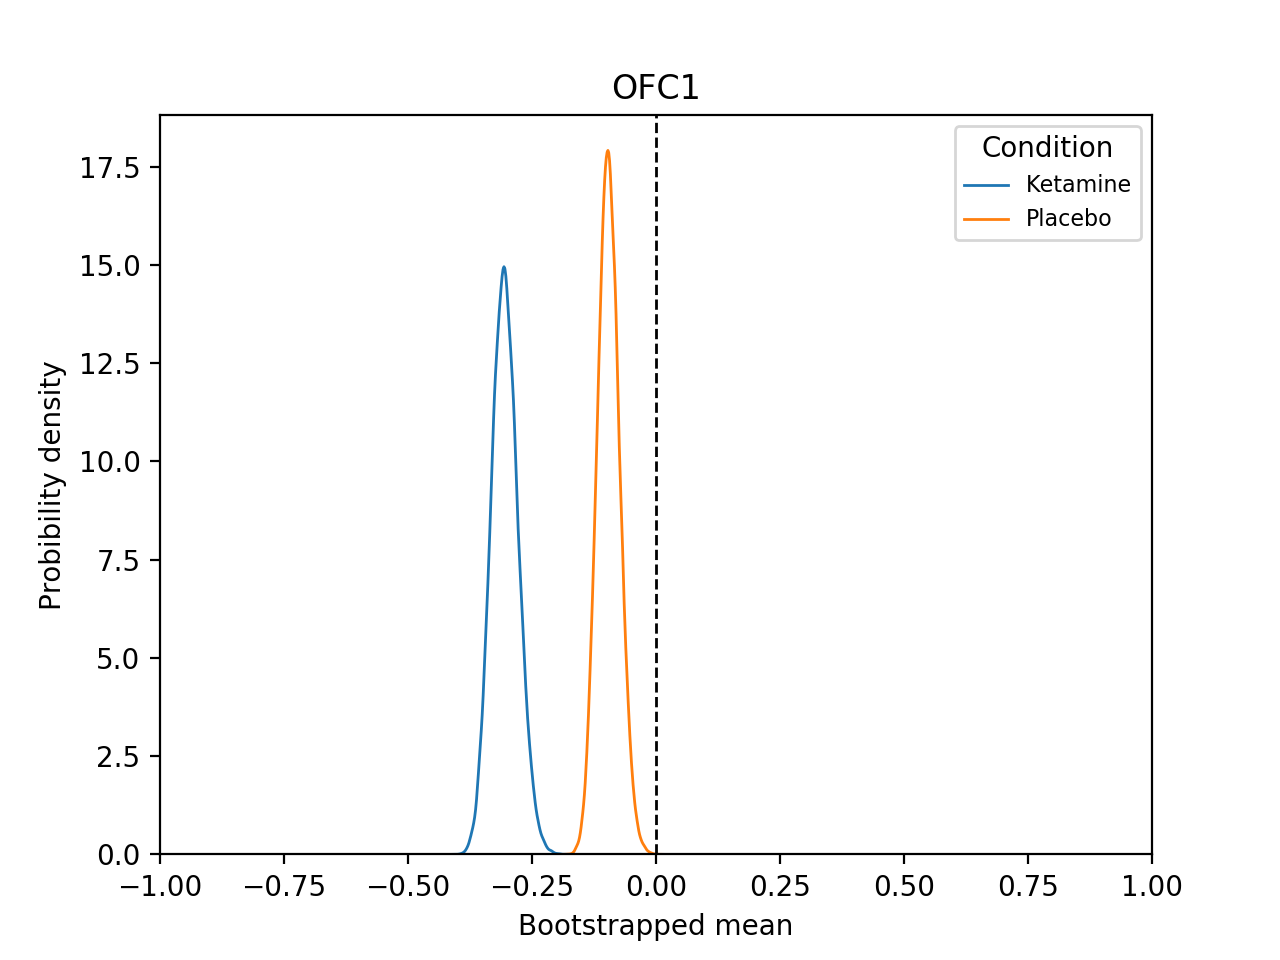

In [54]:
plot_ket_placebo(ofc, 'OFC1')

In [64]:
calulcate_p_value_1(bsr_k)

P value:  0.0


In [65]:
calulcate_p_value_1(bsr_p)

P value:  0.00012


<IPython.core.display.Javascript object>


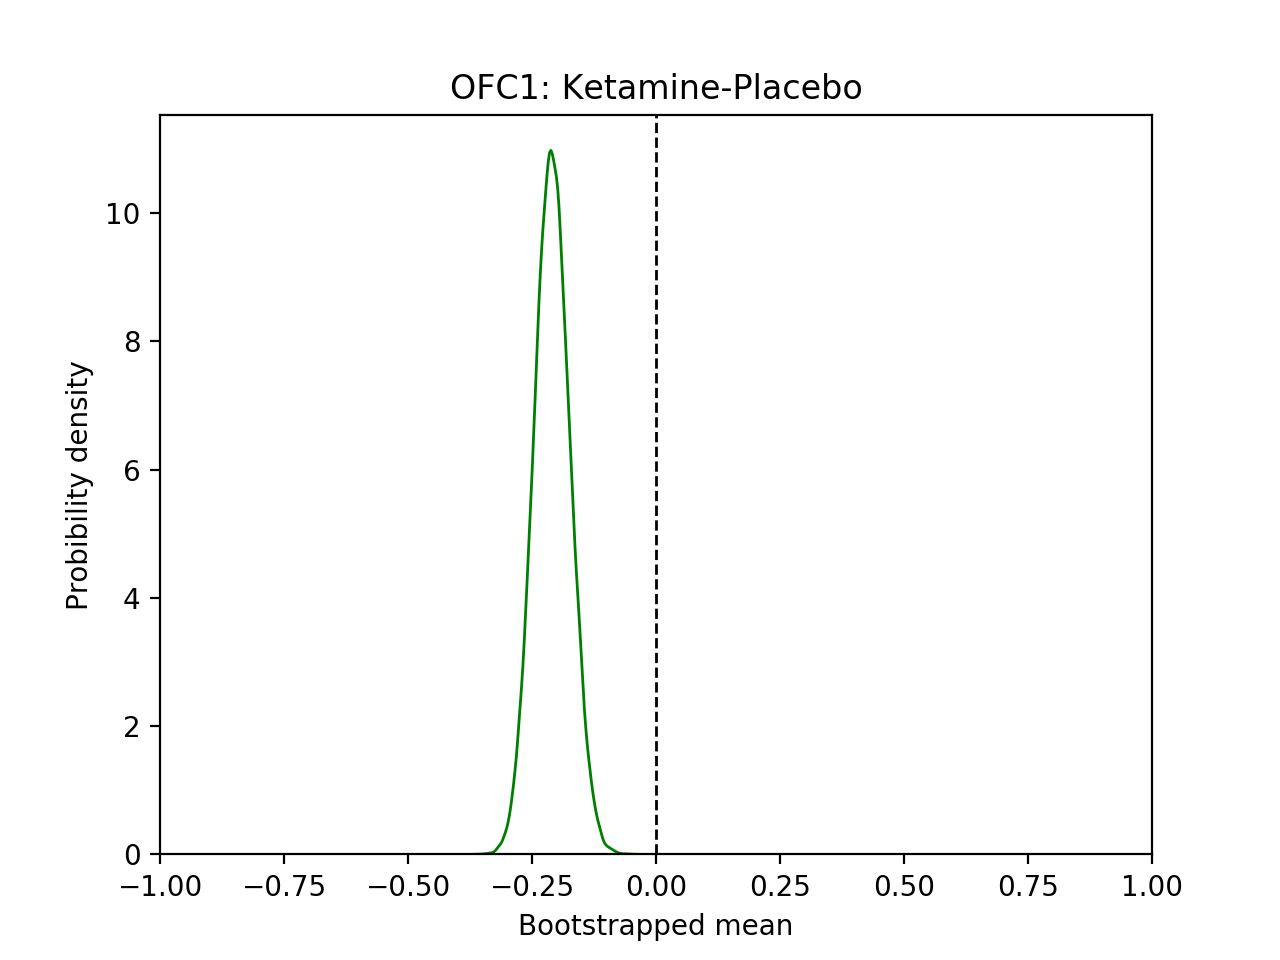

In [55]:
plot_interaction(ofc, 'OFC1')

In [66]:
calulcate_p_value(bsr)

P value:  0.0


# OFC2

In [69]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC2')

<IPython.core.display.Javascript object>


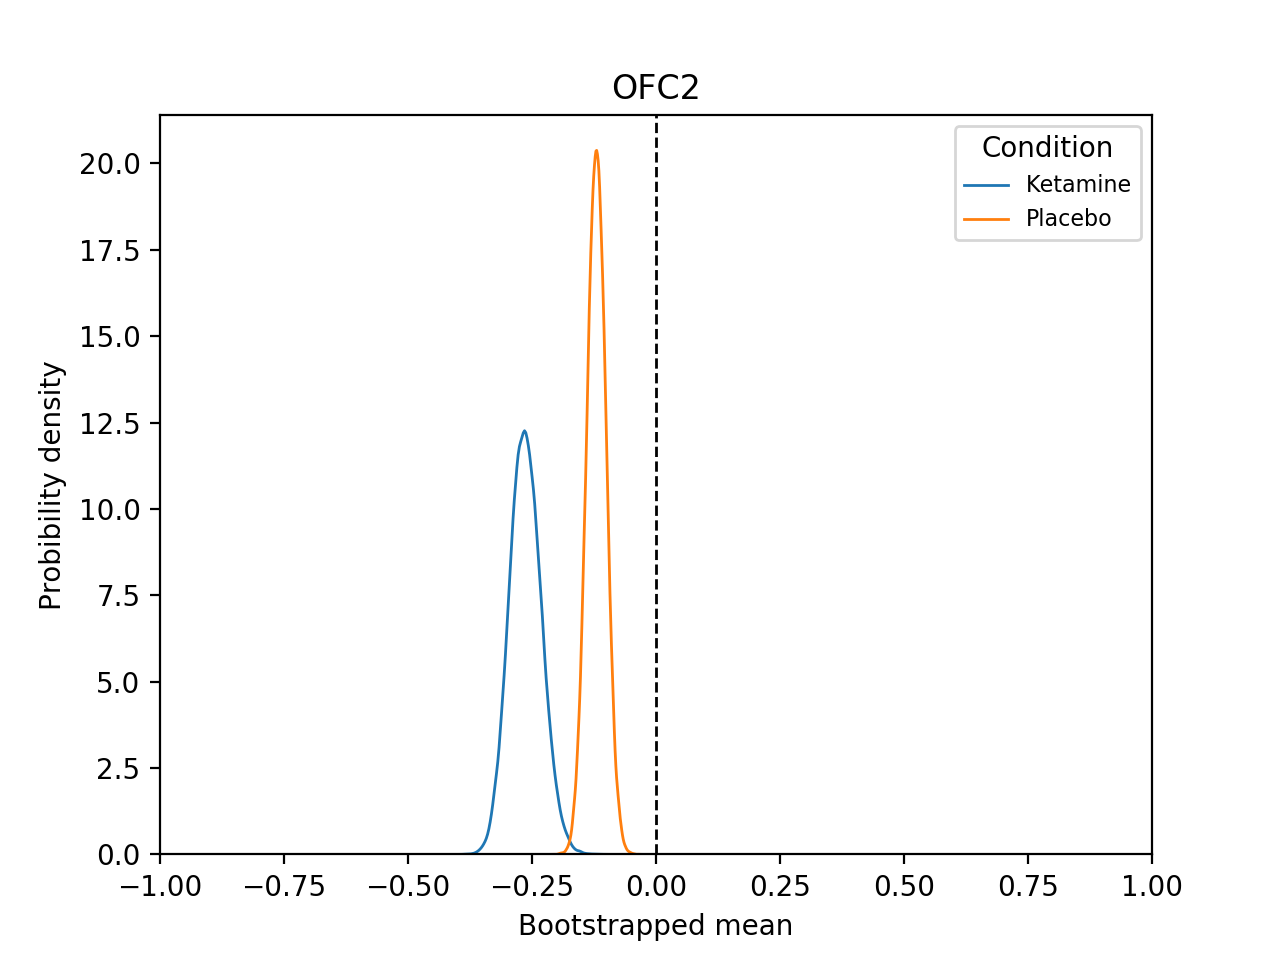

In [70]:
plot_ket_placebo(bsr_com, 'OFC2')

In [71]:
calulcate_p_value_1(bsr_k)

P value:  0.0


In [72]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


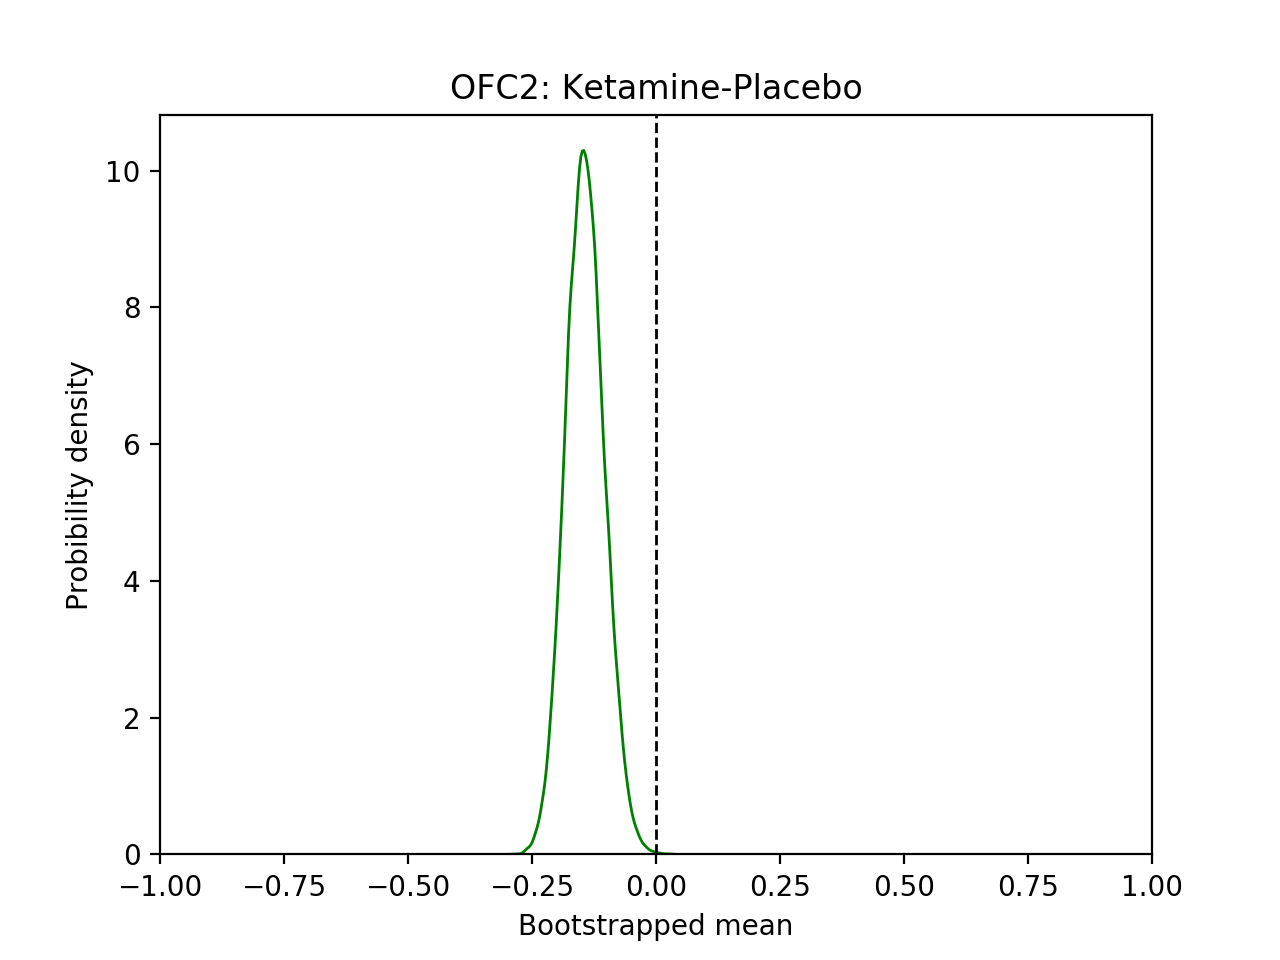

In [73]:
plot_interaction(bsr_com, 'OFC2')

In [74]:
calulcate_p_value_1(bsr)

P value:  0.00084


# OFC3

In [75]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC3')

<IPython.core.display.Javascript object>


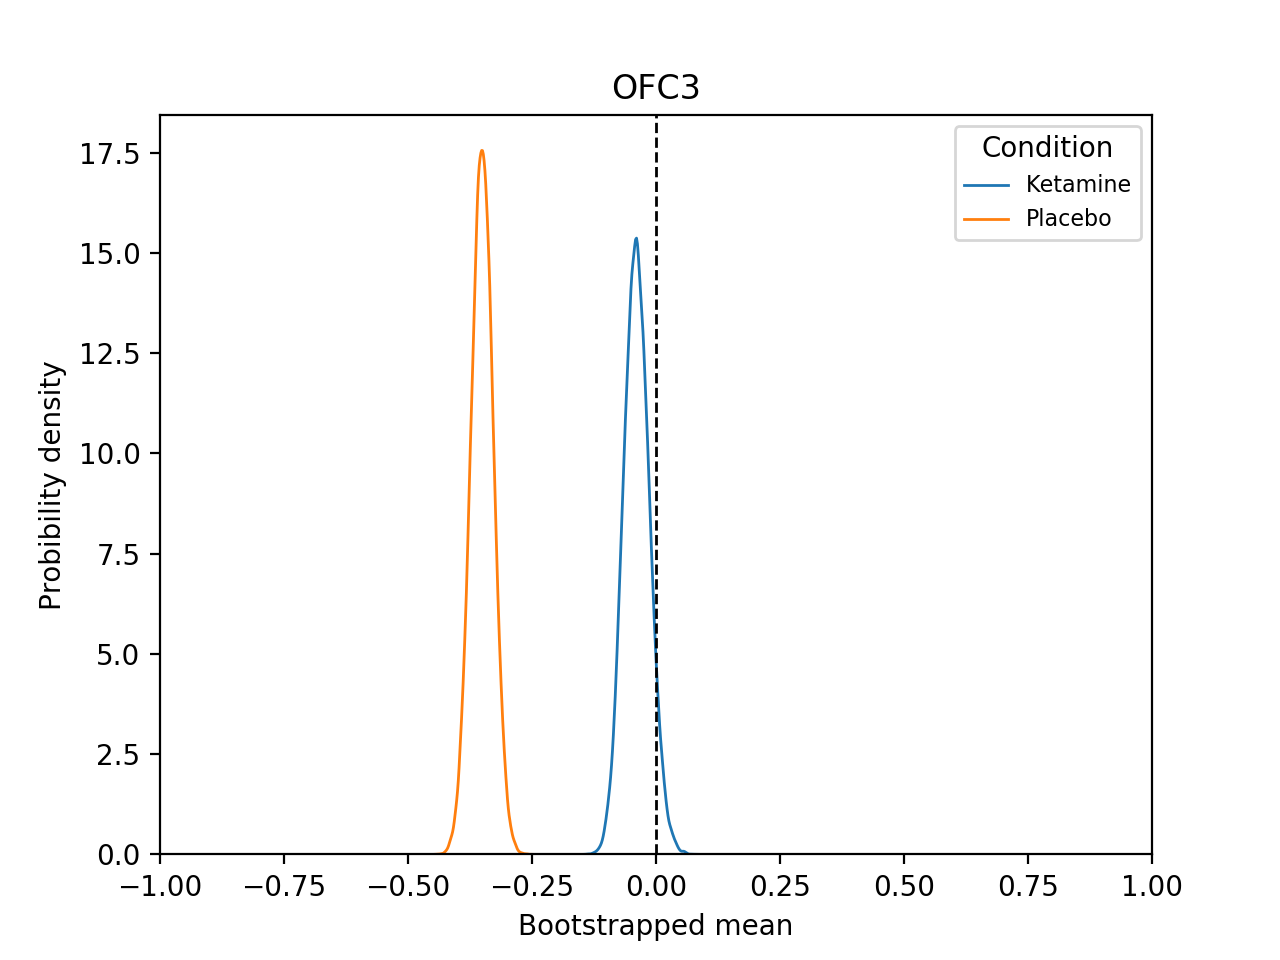

In [76]:
plot_ket_placebo(bsr_com, 'OFC3')

In [77]:
calulcate_p_value_1(bsr_k)

P value:  0.1466


In [78]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


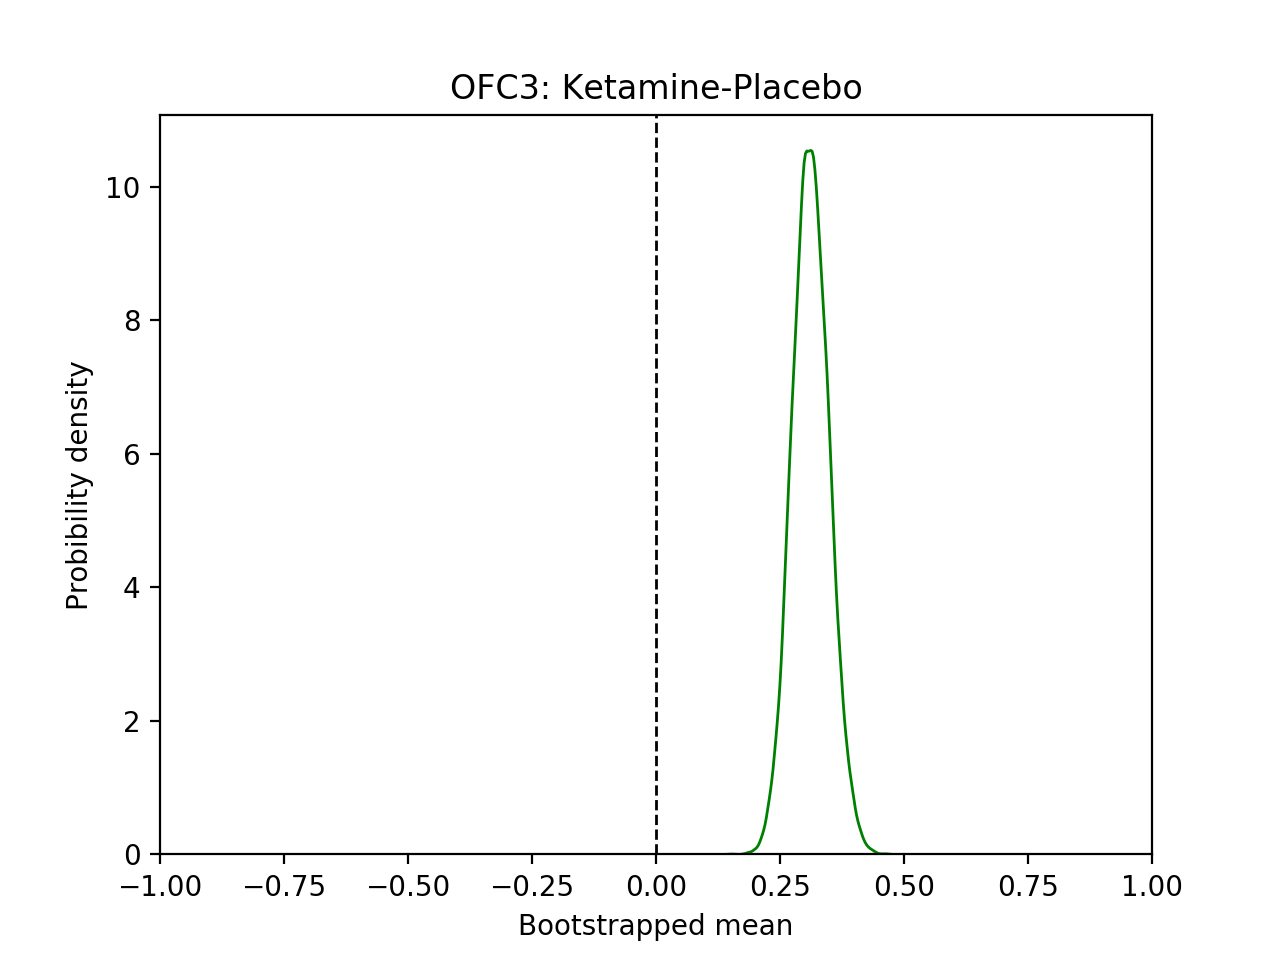

In [79]:
plot_interaction(bsr_com, 'OFC3')

In [81]:
calulcate_p_value_2(bsr)

P value:  0.0


# OFC4

In [82]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC4')

<IPython.core.display.Javascript object>


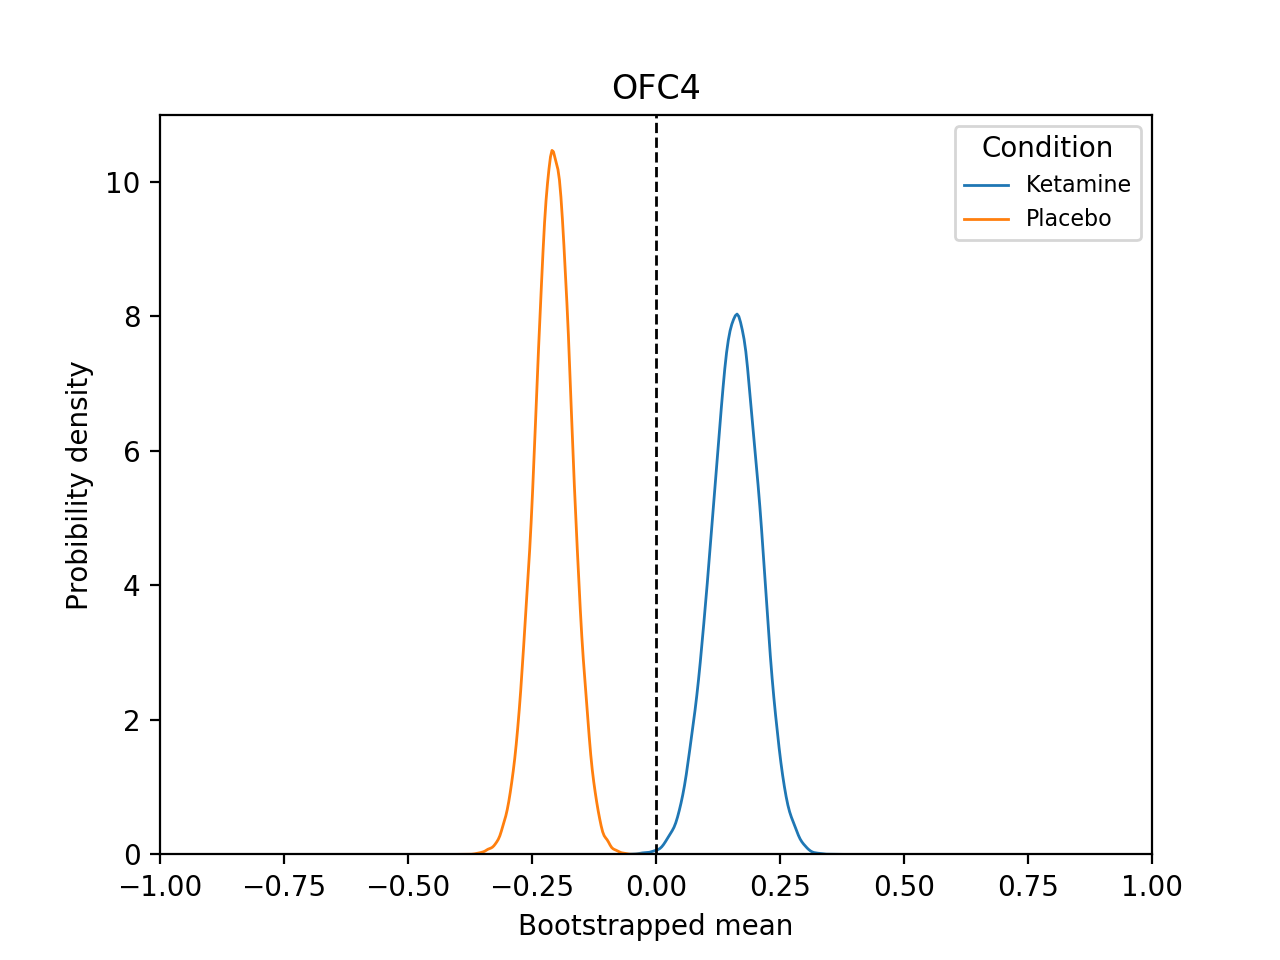

In [83]:
plot_ket_placebo(bsr_com, 'OFC4')

In [85]:
calulcate_p_value_2(bsr_k)

P value:  0.0024


In [86]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


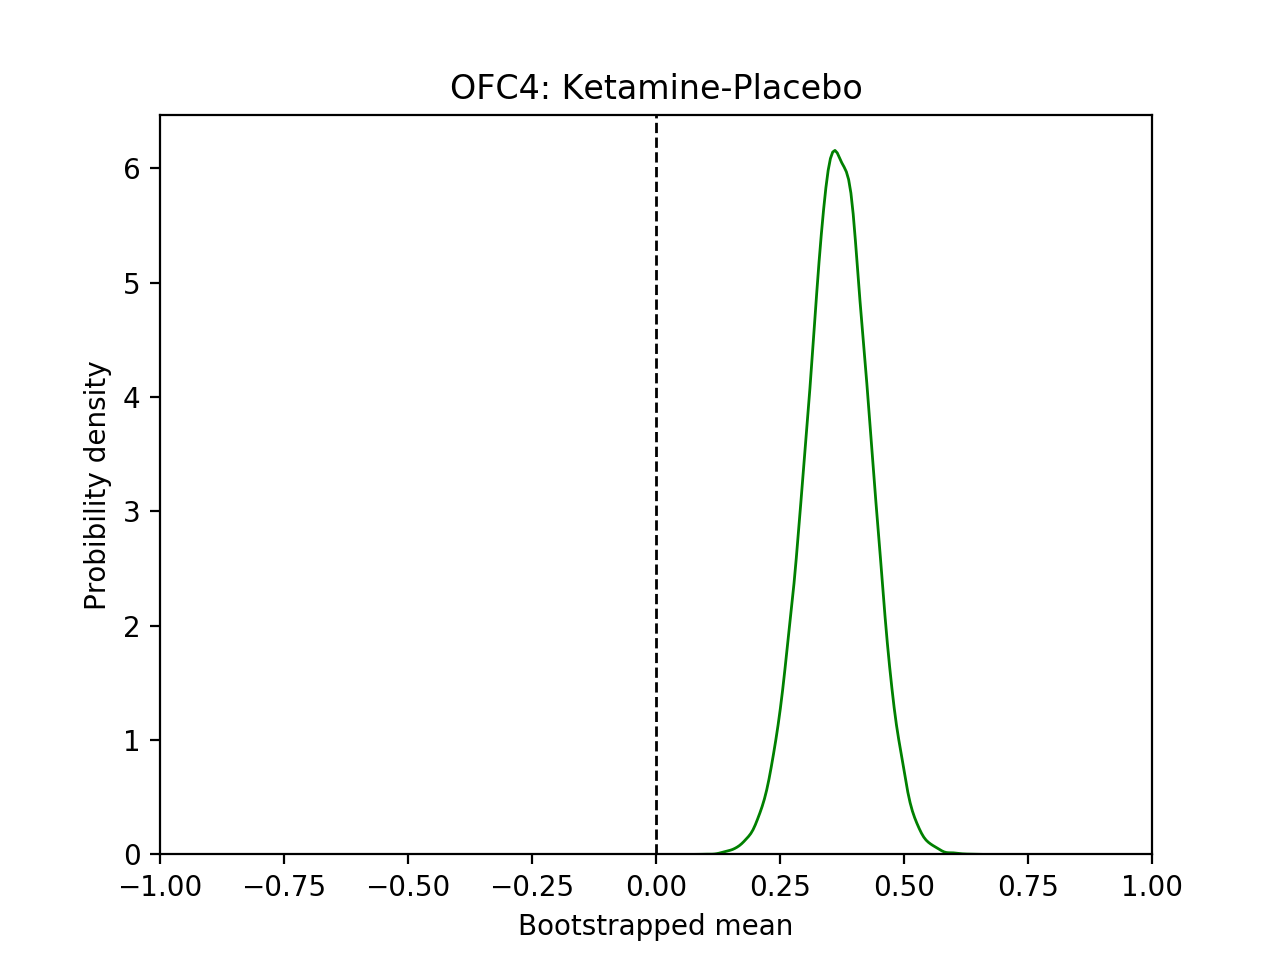

In [87]:
plot_interaction(bsr_com, 'OFC4')

In [88]:
calulcate_p_value_2(bsr)

P value:  0.0


# OFC5

In [89]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC5')

<IPython.core.display.Javascript object>


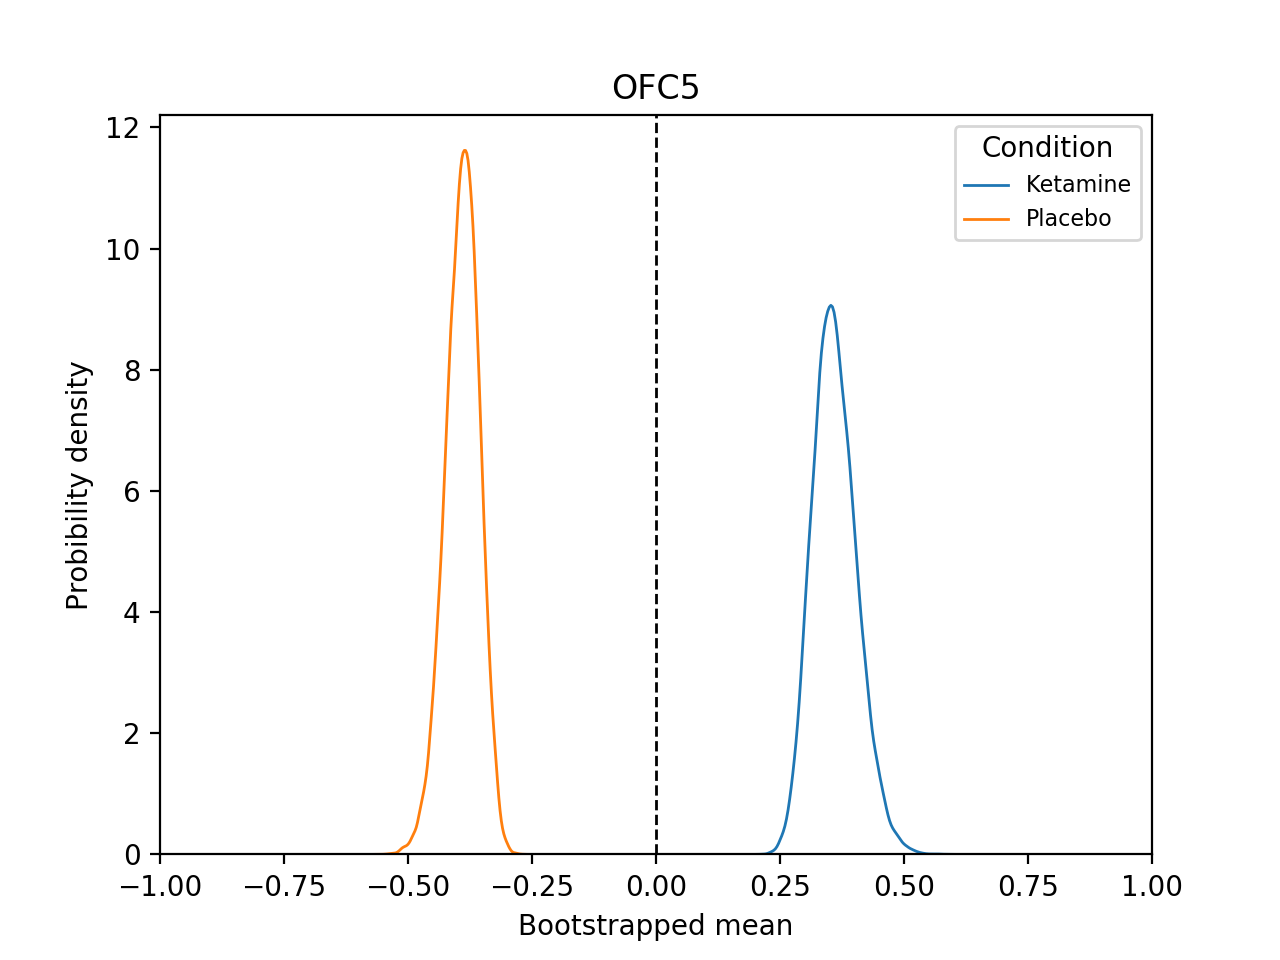

In [90]:
plot_ket_placebo(bsr_com, 'OFC5')

In [91]:
calulcate_p_value_2(bsr_k)

P value:  0.0


In [92]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


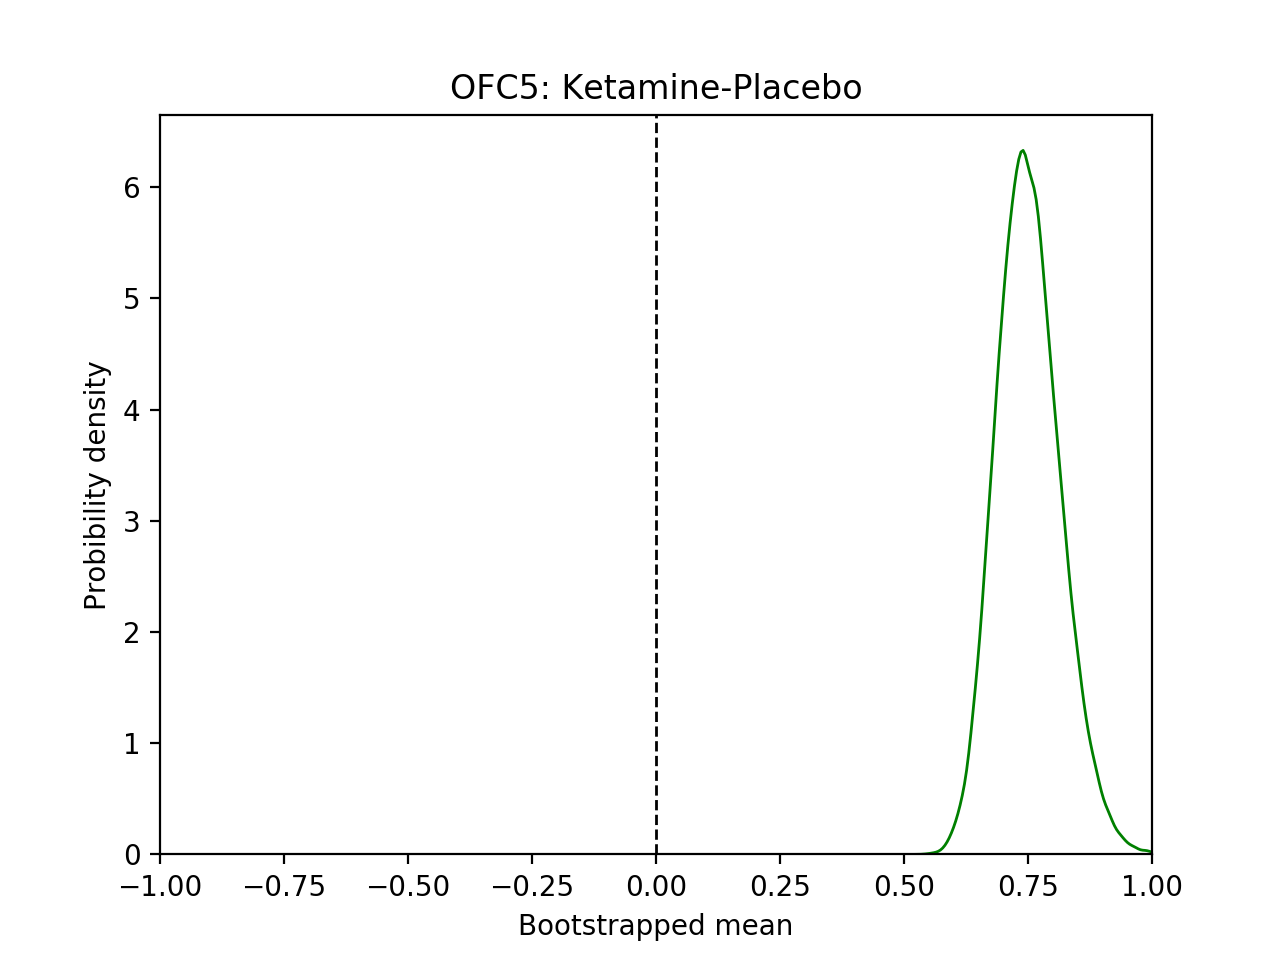

In [93]:
plot_interaction(bsr_com, 'OFC5')

In [94]:
calulcate_p_value_2(bsr)

P value:  0.0


# OFC6

In [95]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC6')

<IPython.core.display.Javascript object>


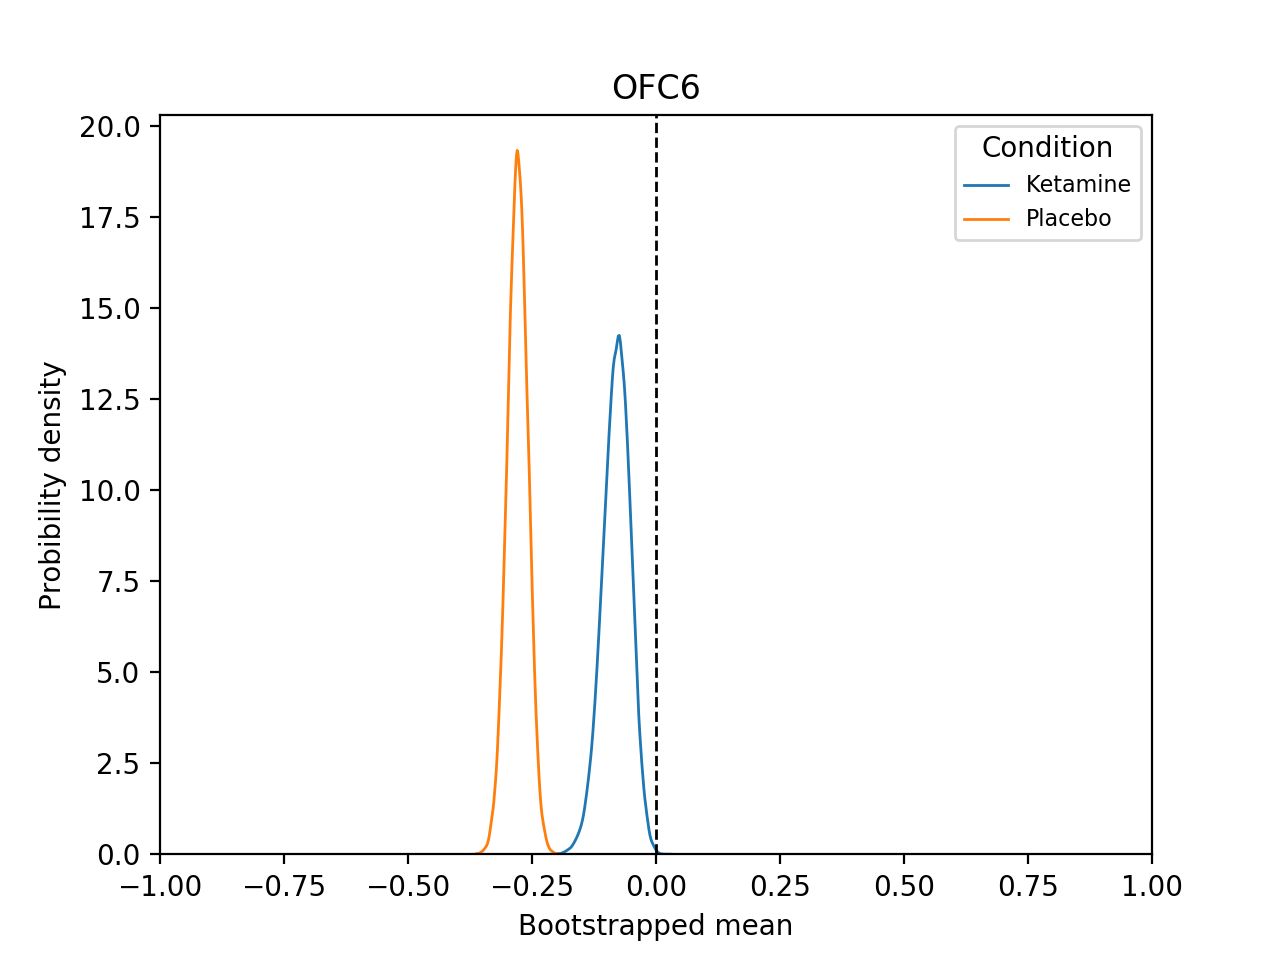

In [96]:
plot_ket_placebo(bsr_com, 'OFC6')

In [97]:
calulcate_p_value_1(bsr_k)

P value:  0.00112


In [98]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


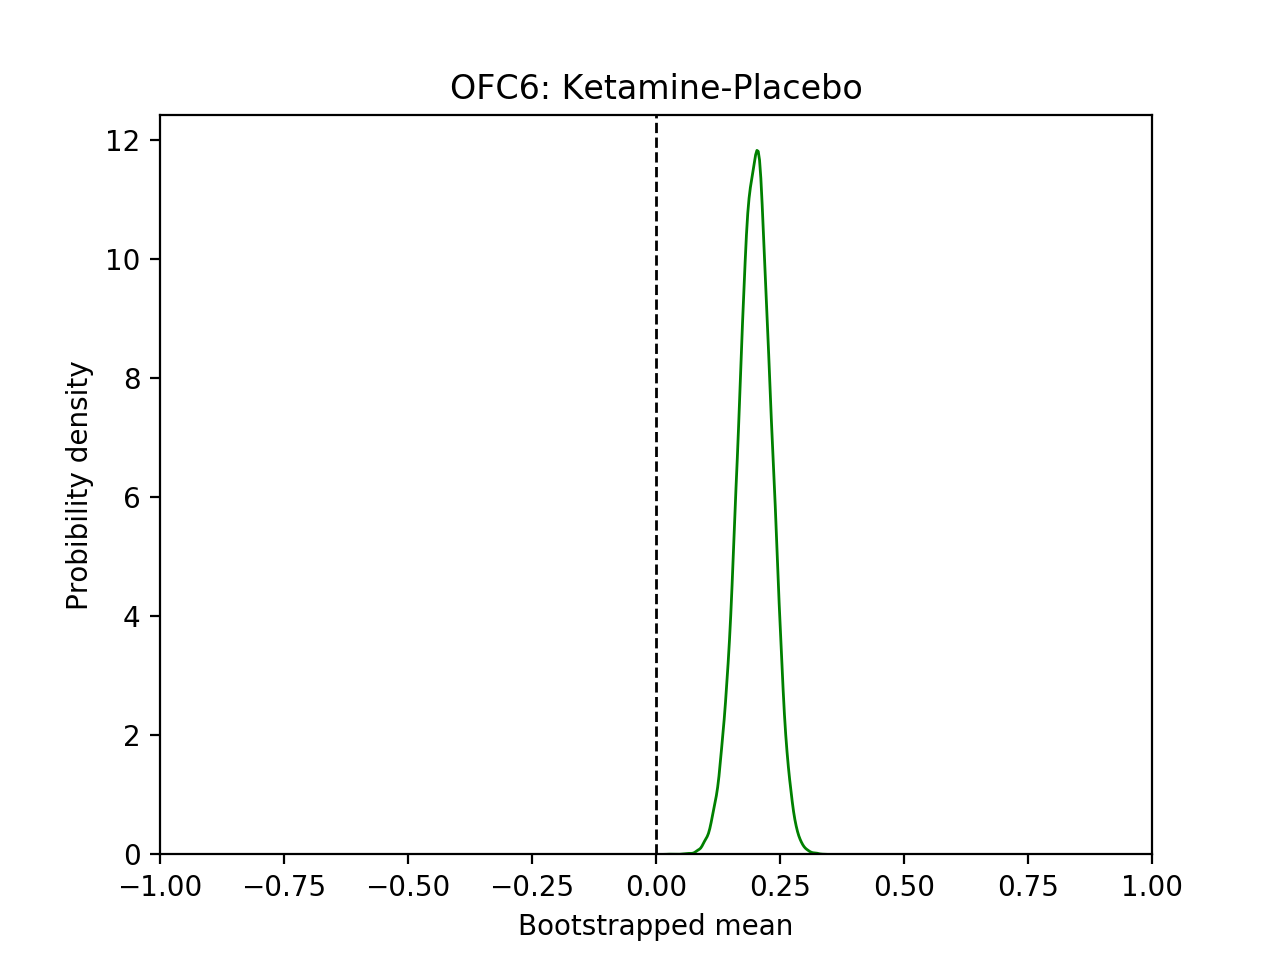

In [99]:
plot_interaction(bsr_com, 'OFC6')

In [101]:
calulcate_p_value_2(bsr)

P value:  0.0


# OFC7

In [102]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('OFC7')

<IPython.core.display.Javascript object>


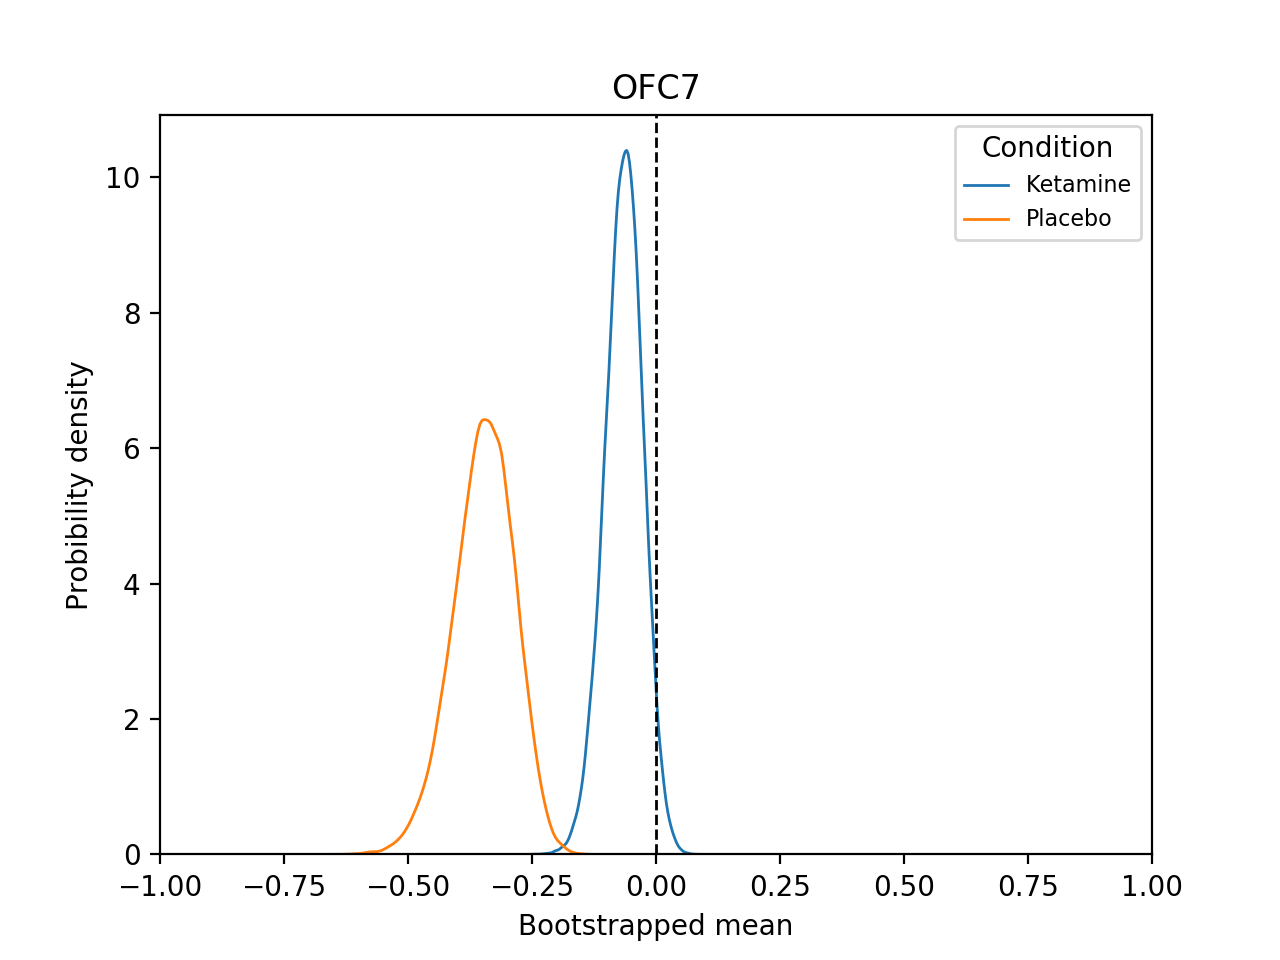

In [103]:
plot_ket_placebo(bsr_com, 'OFC7')

In [104]:
calulcate_p_value_1(bsr_k)

P value:  0.07904


In [105]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


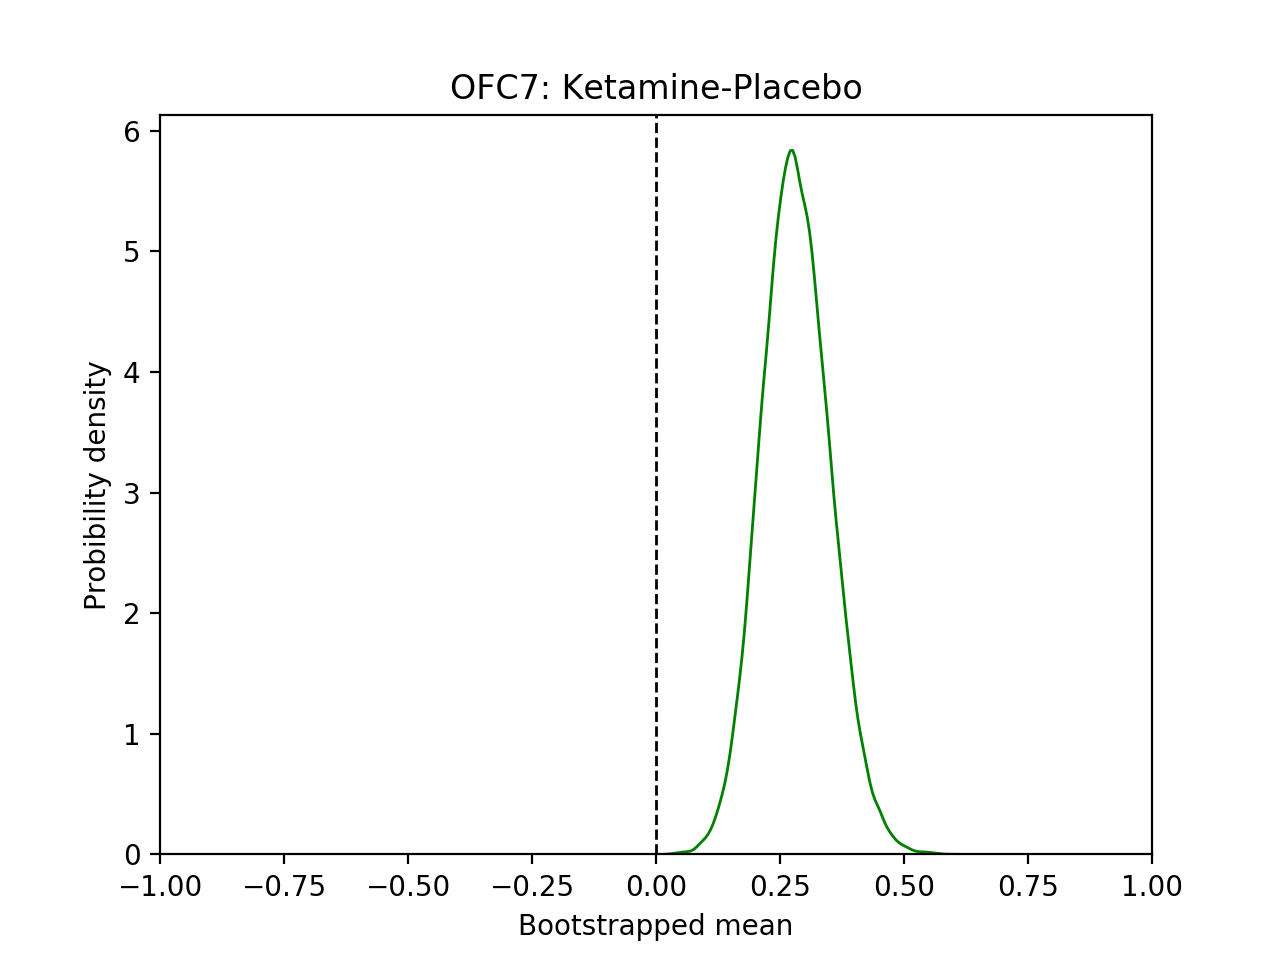

In [106]:
plot_interaction(bsr_com, 'OFC7')

In [107]:
calulcate_p_value_2(bsr)

P value:  0.0


# FP2

In [108]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('FP2')

<IPython.core.display.Javascript object>


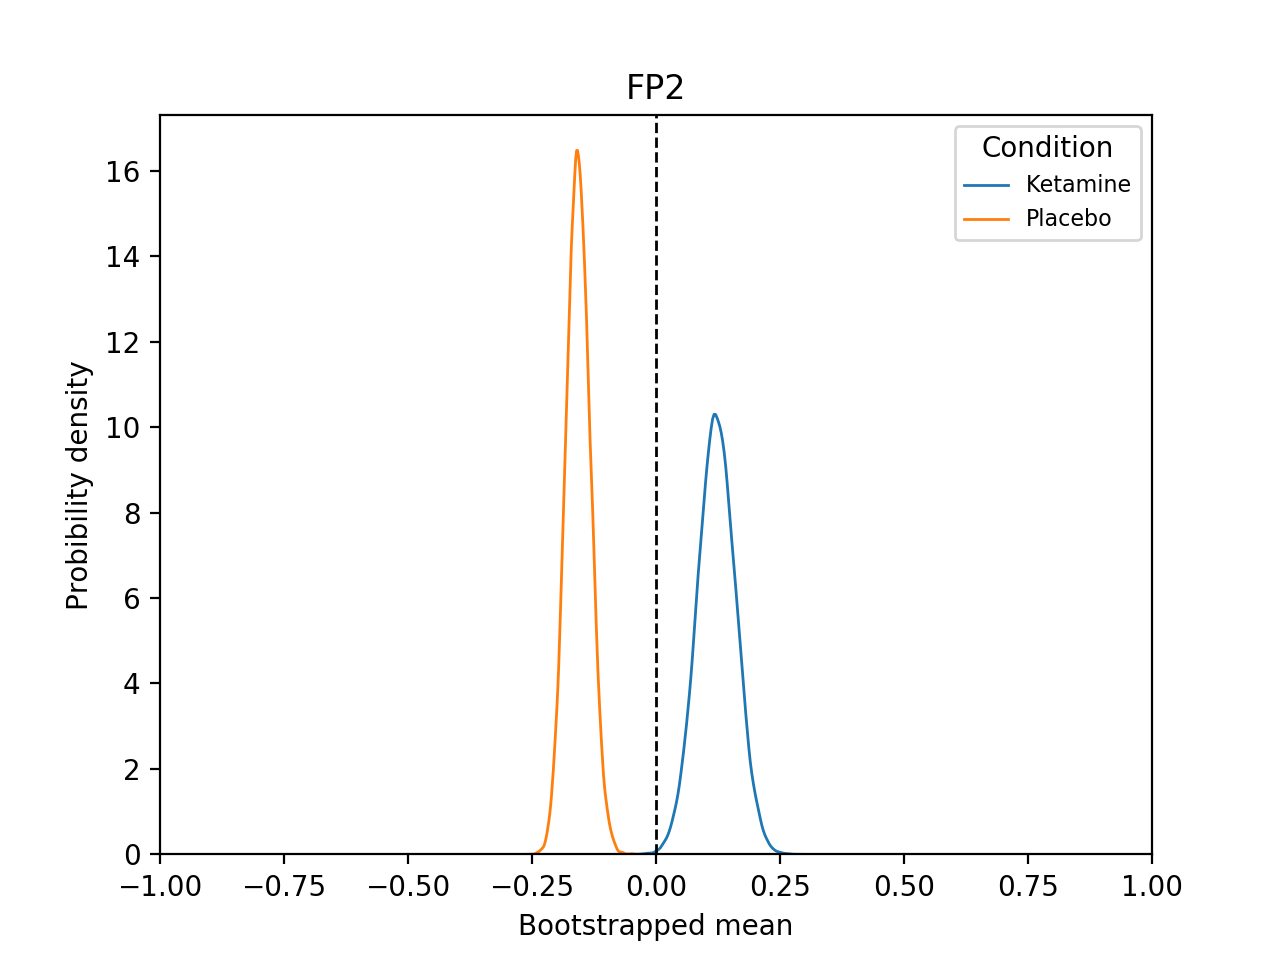

In [109]:
plot_ket_placebo(bsr_com, 'FP2')

In [110]:
calulcate_p_value_2(bsr_k)

P value:  0.00184


In [111]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


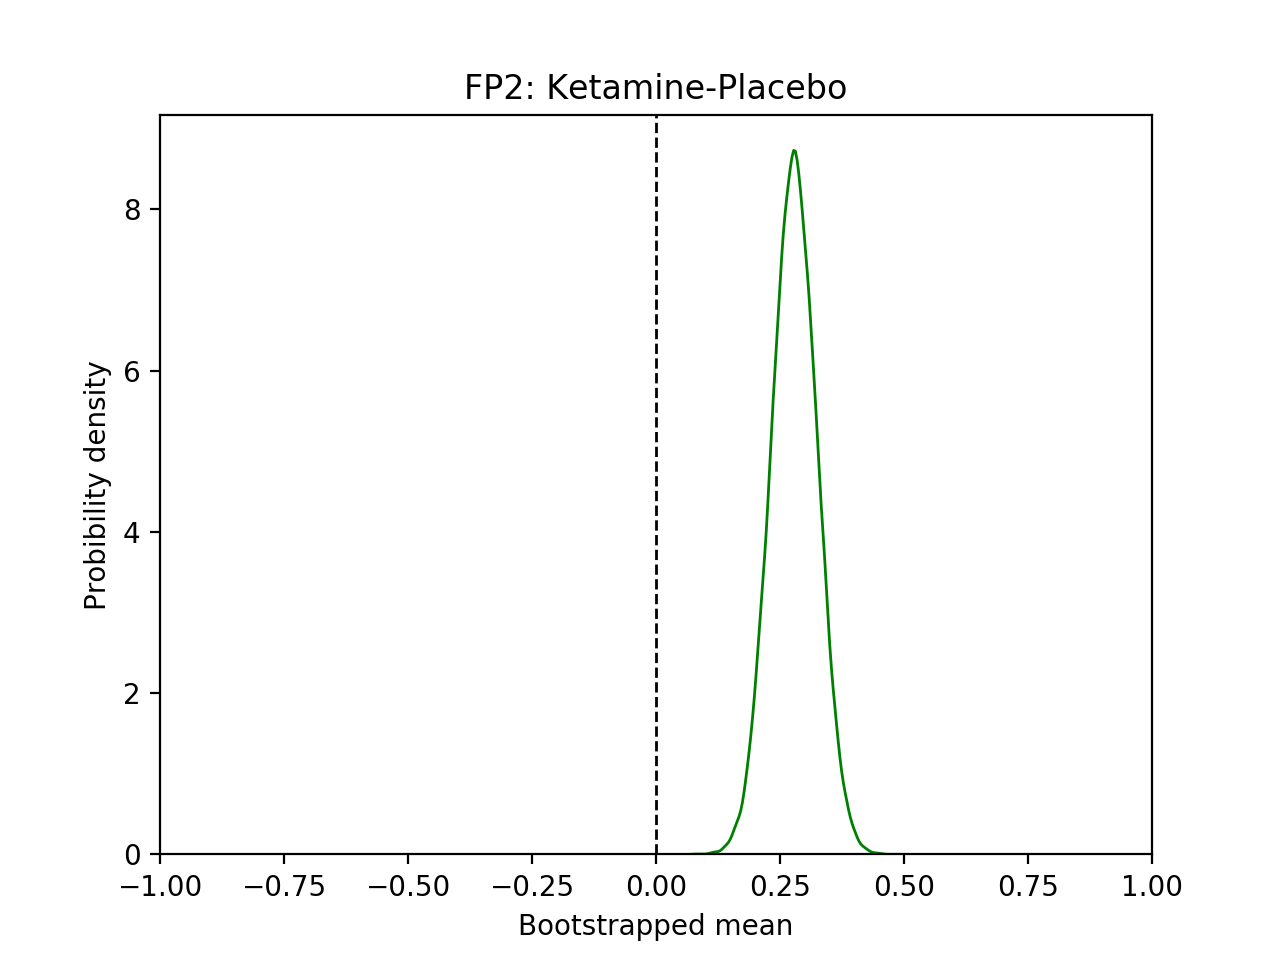

In [112]:
plot_interaction(bsr_com, 'FP2')

In [113]:
calulcate_p_value_2(bsr)

P value:  0.0


# 25

In [200]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('25')

<IPython.core.display.Javascript object>


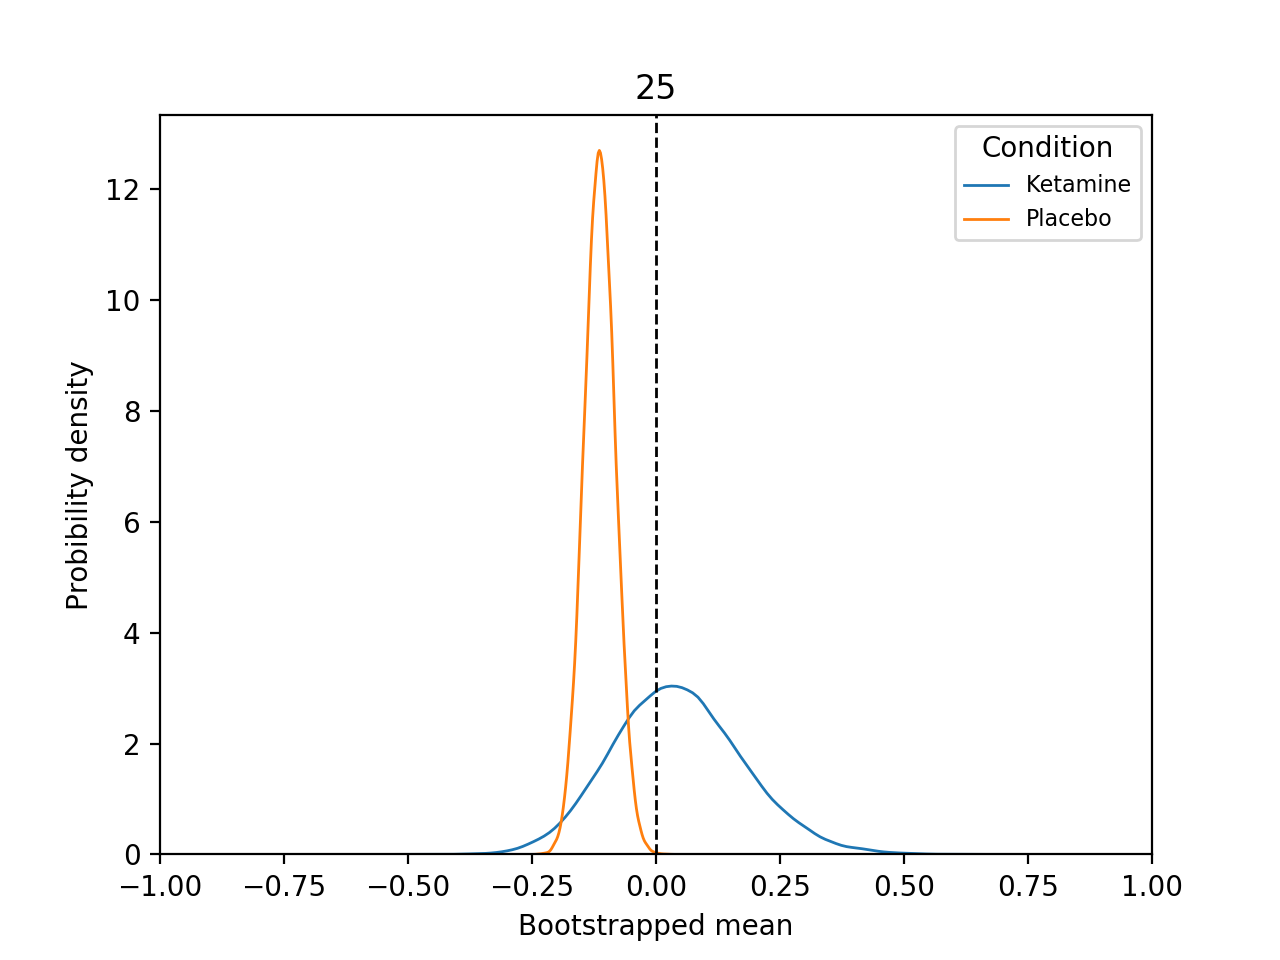

In [201]:
plot_ket_placebo(bsr_com, '25')

In [202]:
calulcate_p_value_2(bsr_k)

P value:  0.7604


In [203]:
calulcate_p_value_1(bsr_p)

P value:  0.00064


<IPython.core.display.Javascript object>


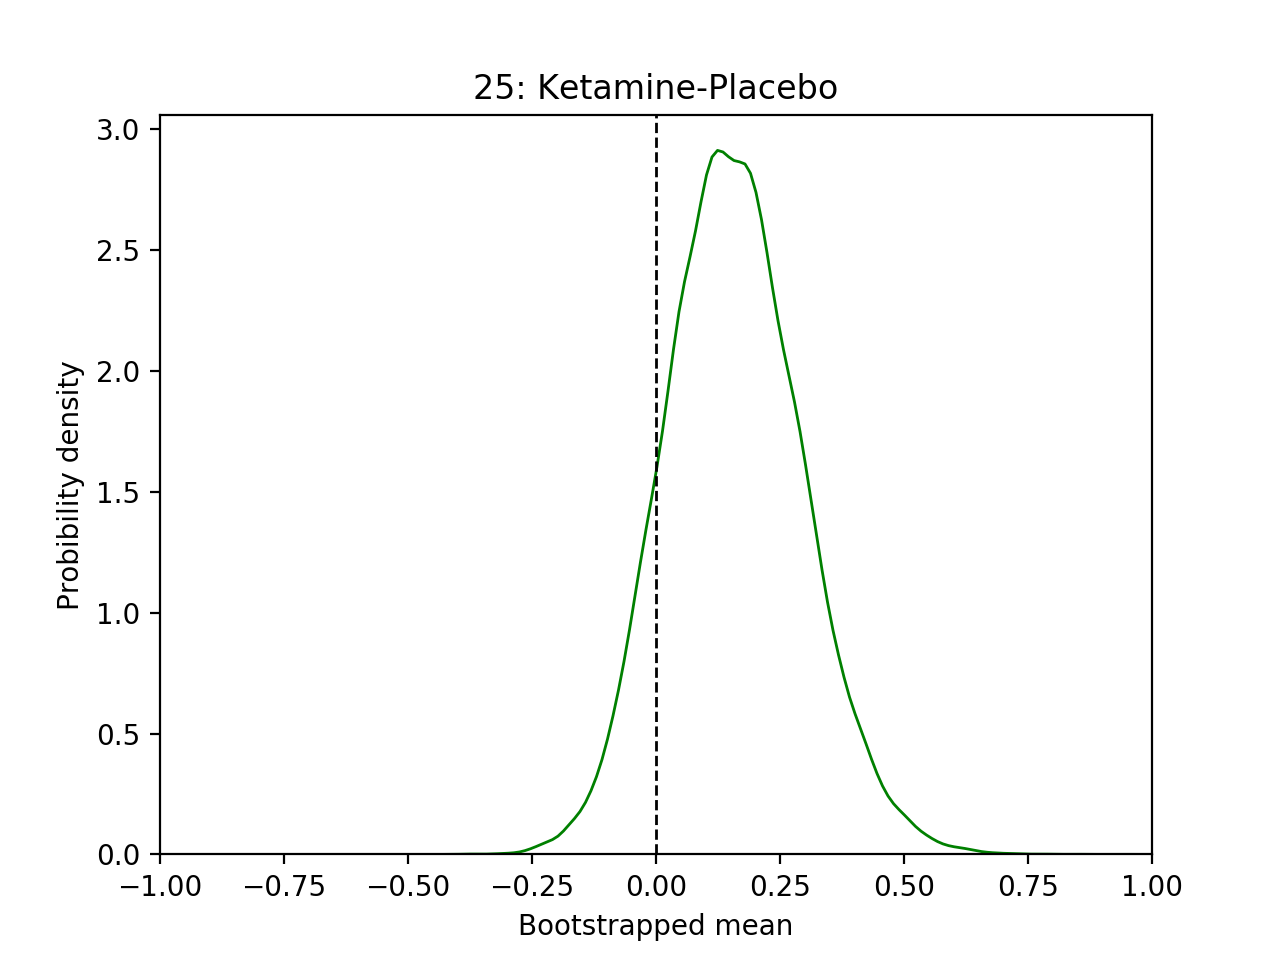

In [204]:
plot_interaction(bsr_com, '25')

In [205]:
calulcate_p_value_2(bsr)

P value:  0.24344


# 33

In [122]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('33')

<IPython.core.display.Javascript object>


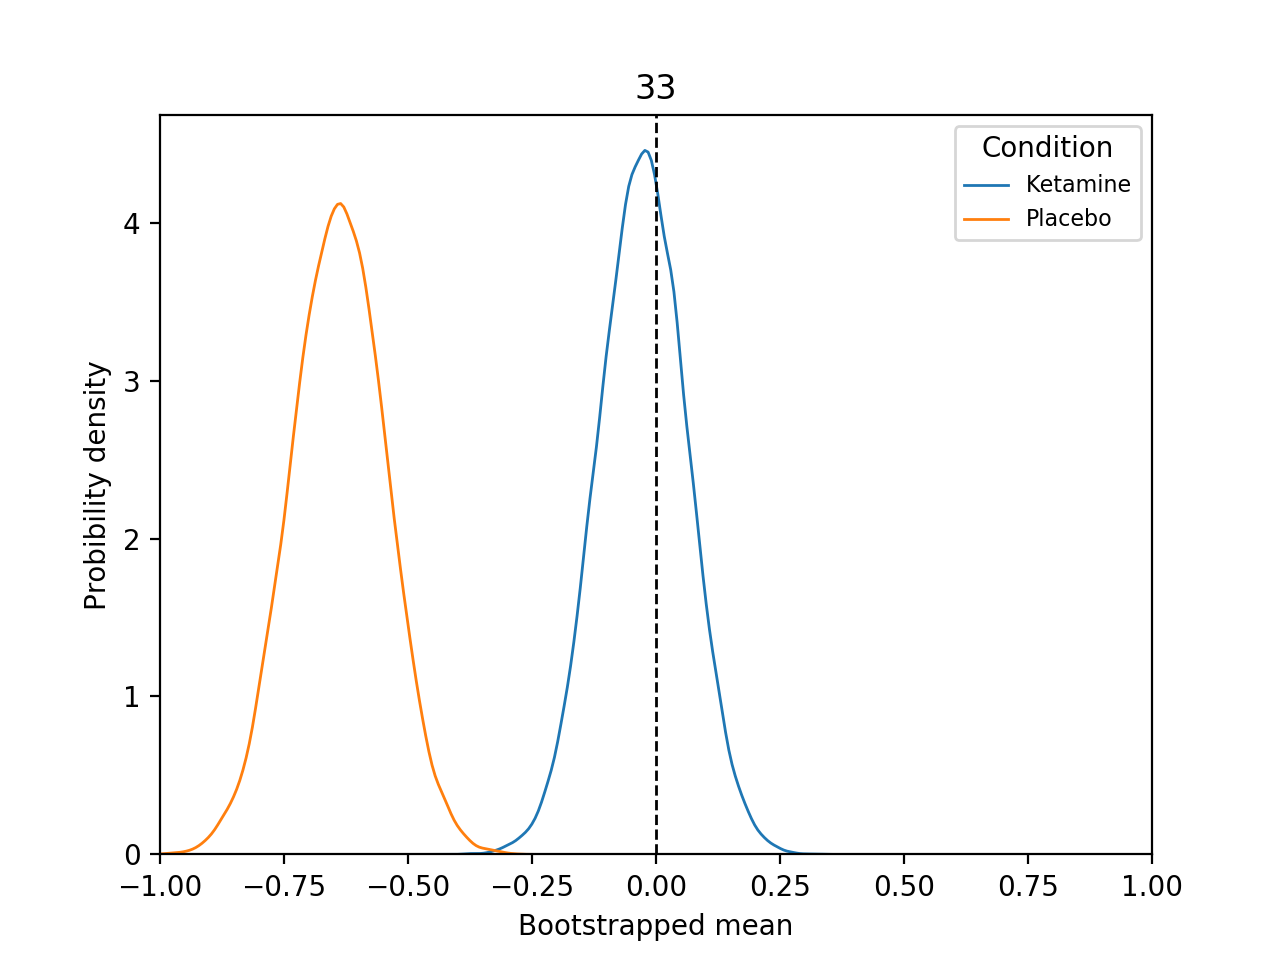

In [123]:
plot_ket_placebo(bsr_com, '33')

In [125]:
calulcate_p_value_2(bsr_k)

P value:  1.236


In [126]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


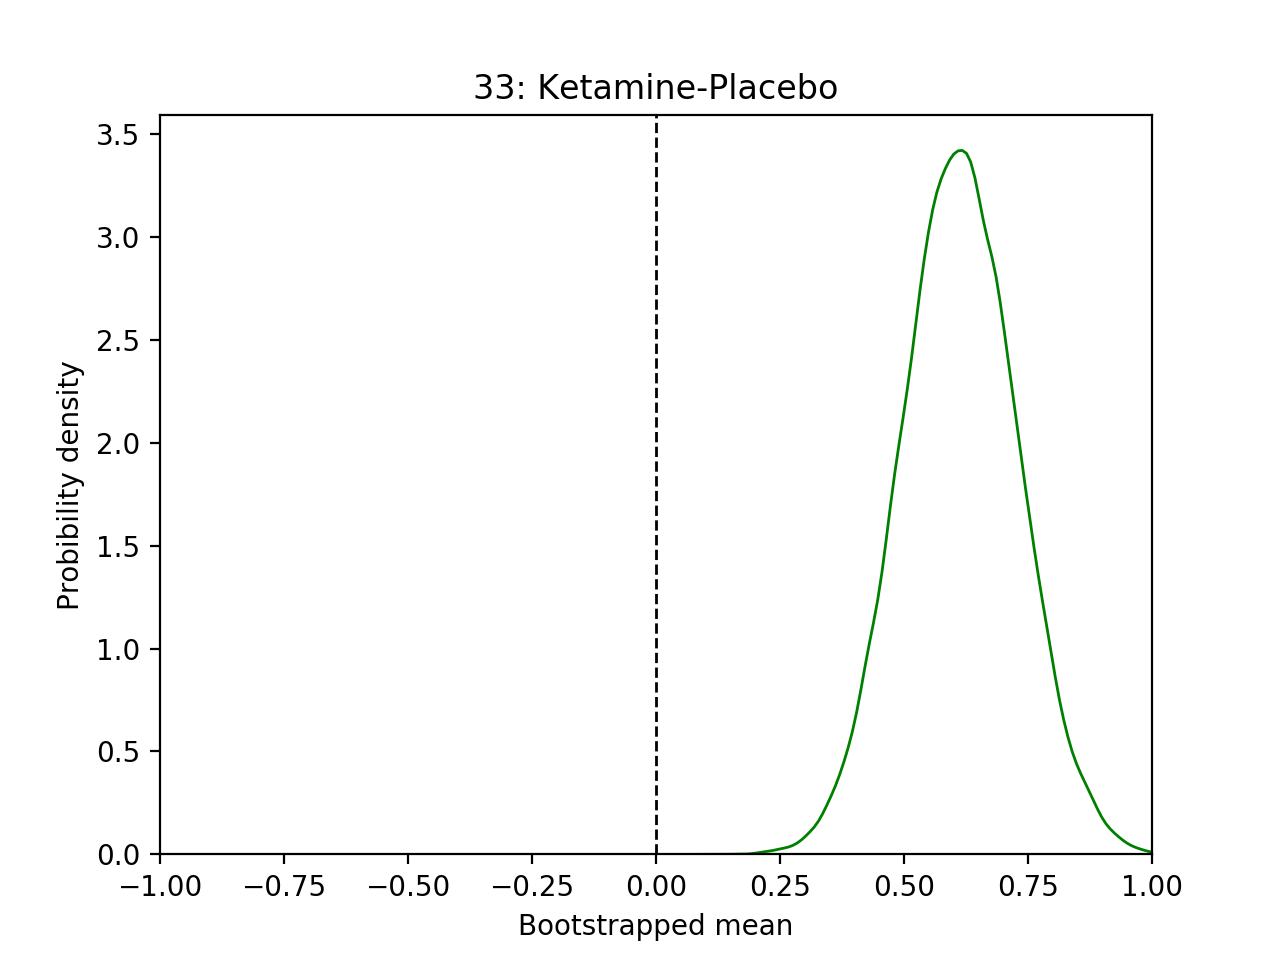

In [127]:
plot_interaction(bsr_com, '33')

In [128]:
calulcate_p_value_2(bsr)

P value:  0.0


# p24c

In [129]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('p24c')

<IPython.core.display.Javascript object>


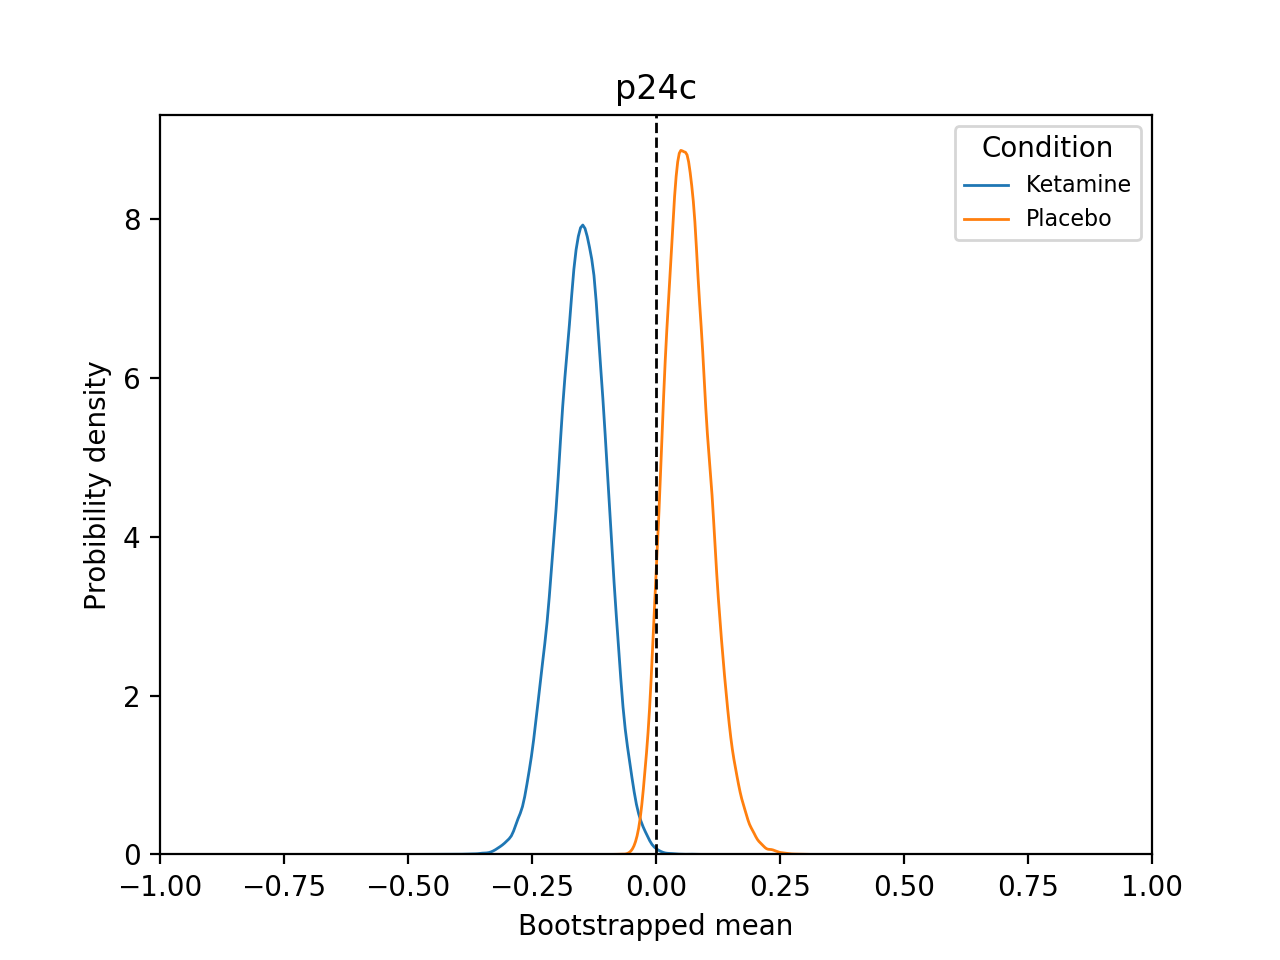

In [130]:
plot_ket_placebo(bsr_com, 'p24c')

In [131]:
calulcate_p_value_1(bsr_k)

P value:  0.00192


In [133]:
calulcate_p_value_2(bsr_p)

P value:  0.11324


<IPython.core.display.Javascript object>


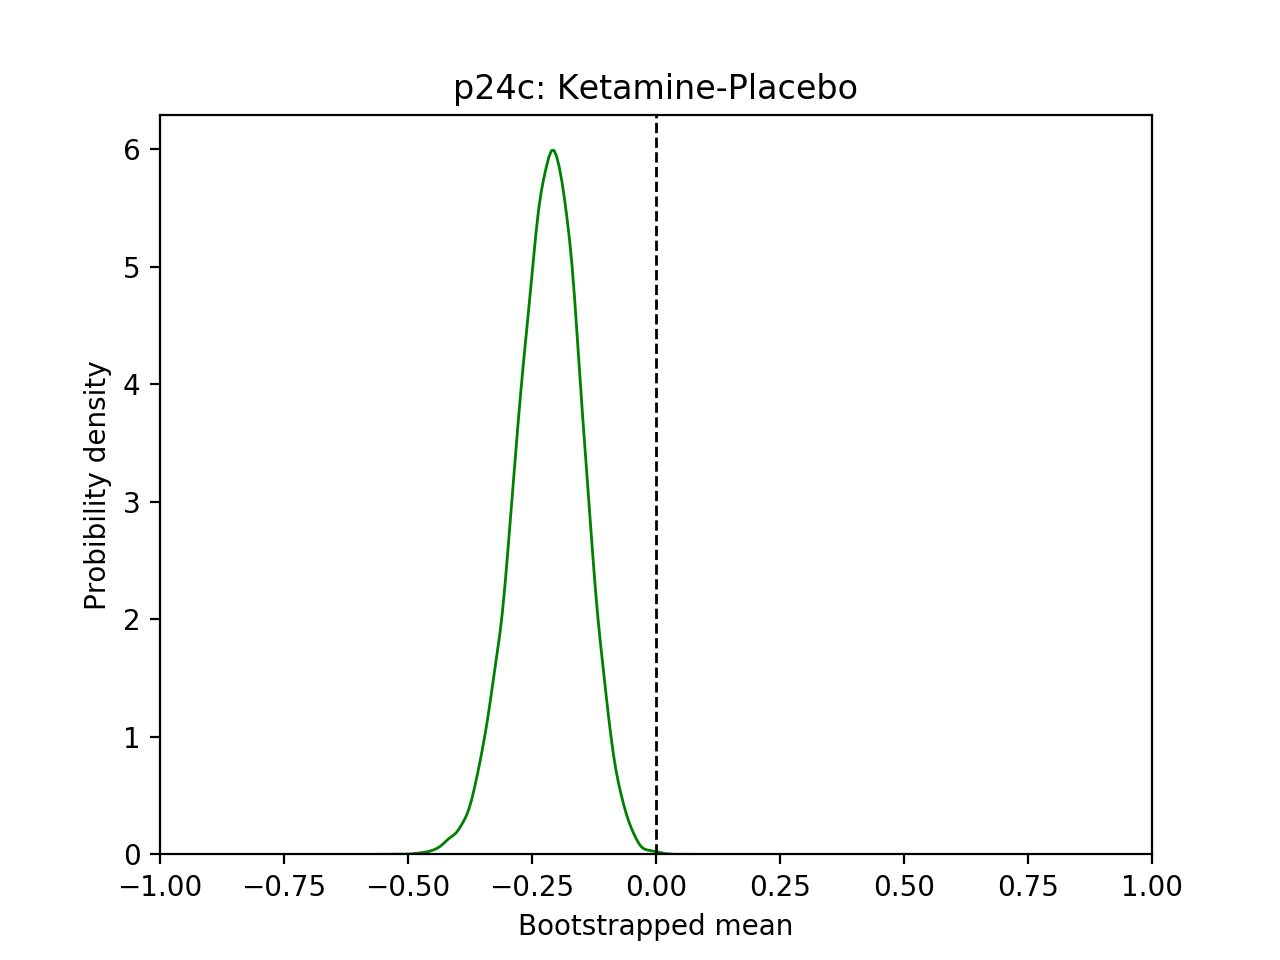

In [134]:
plot_interaction(bsr_com, 'p24c')

In [135]:
calulcate_p_value_1(bsr)

P value:  0.00076


# p24ab

In [136]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('p24ab')

<IPython.core.display.Javascript object>


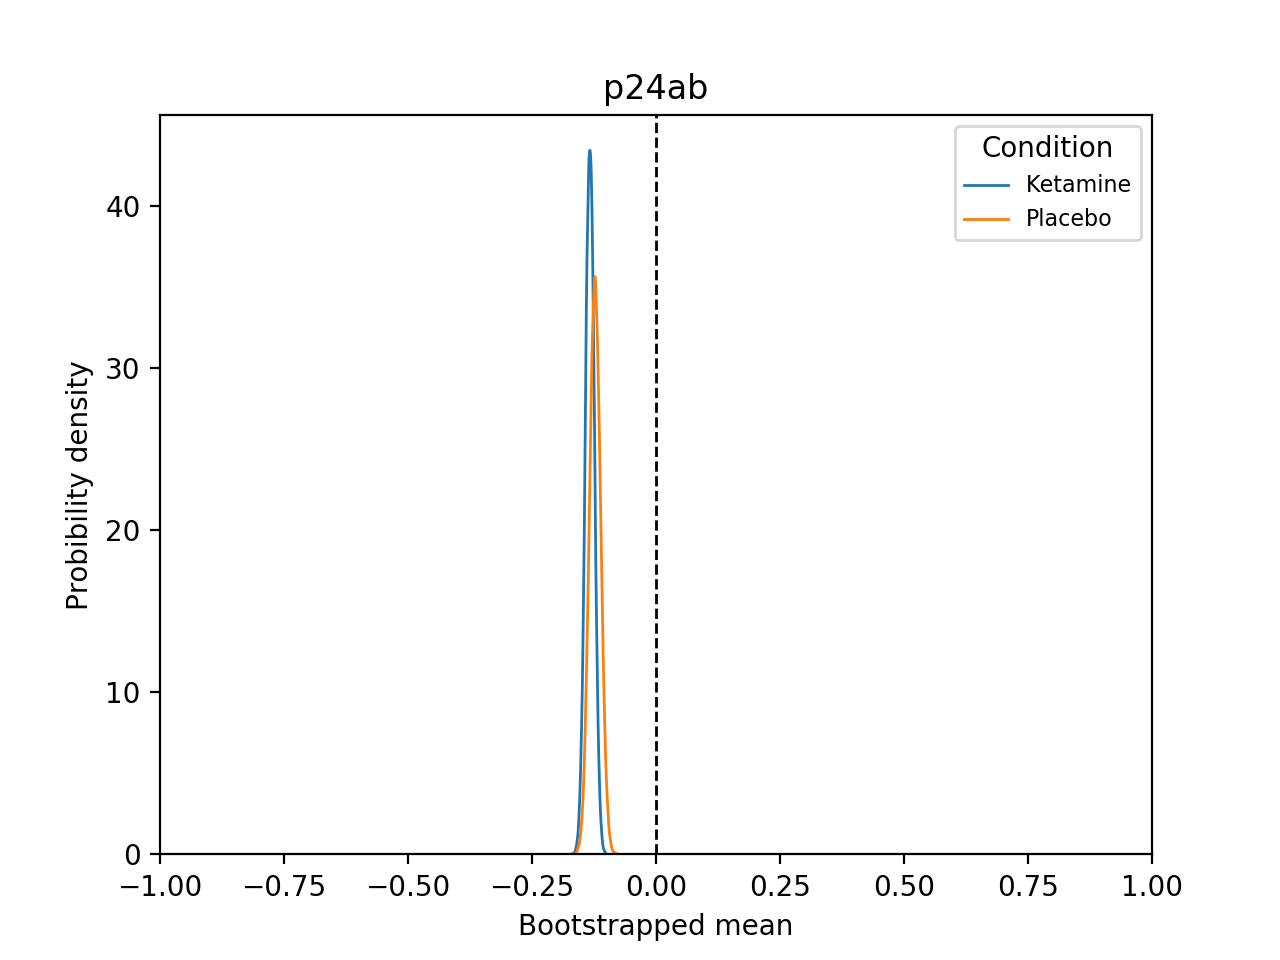

In [137]:
plot_ket_placebo(bsr_com, 'p24ab')

<IPython.core.display.Javascript object>


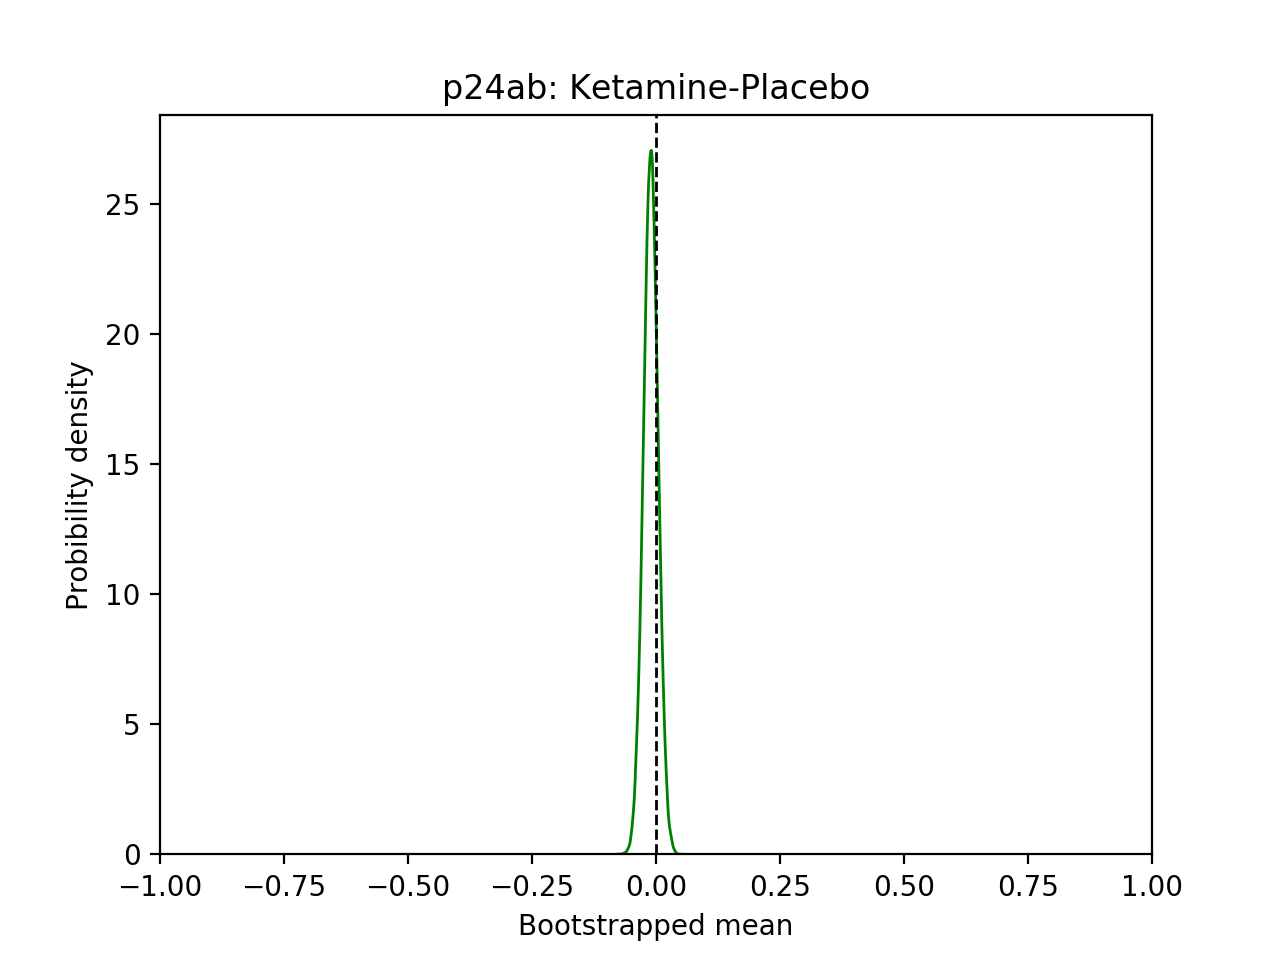

In [138]:
plot_interaction(bsr_com, 'p24ab')

# s32

In [139]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('s32')

<IPython.core.display.Javascript object>


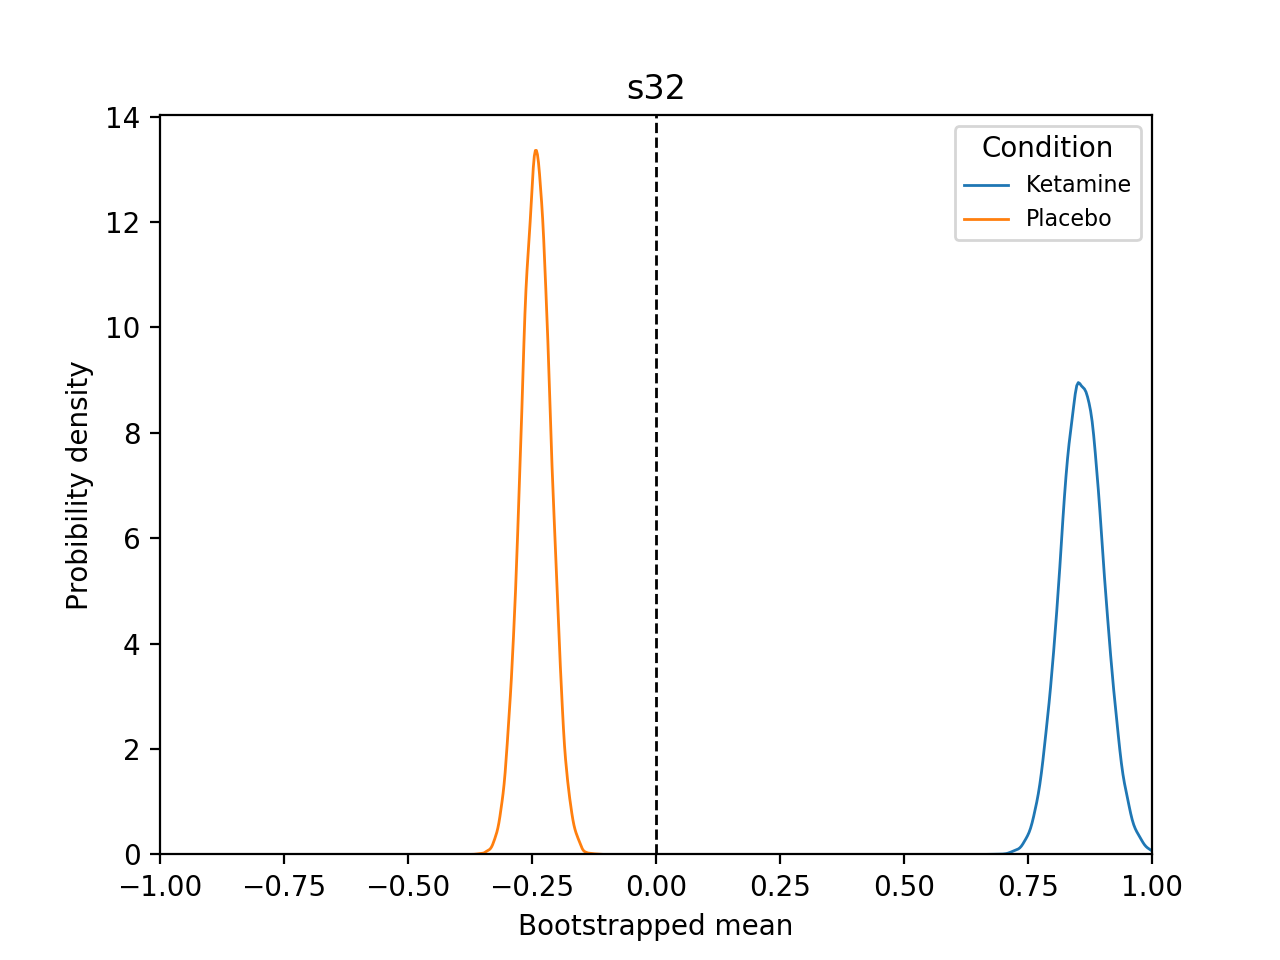

In [140]:
plot_ket_placebo(bsr_com, 's32')

In [142]:
calulcate_p_value_2(bsr_k)

P value:  0.0


In [143]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


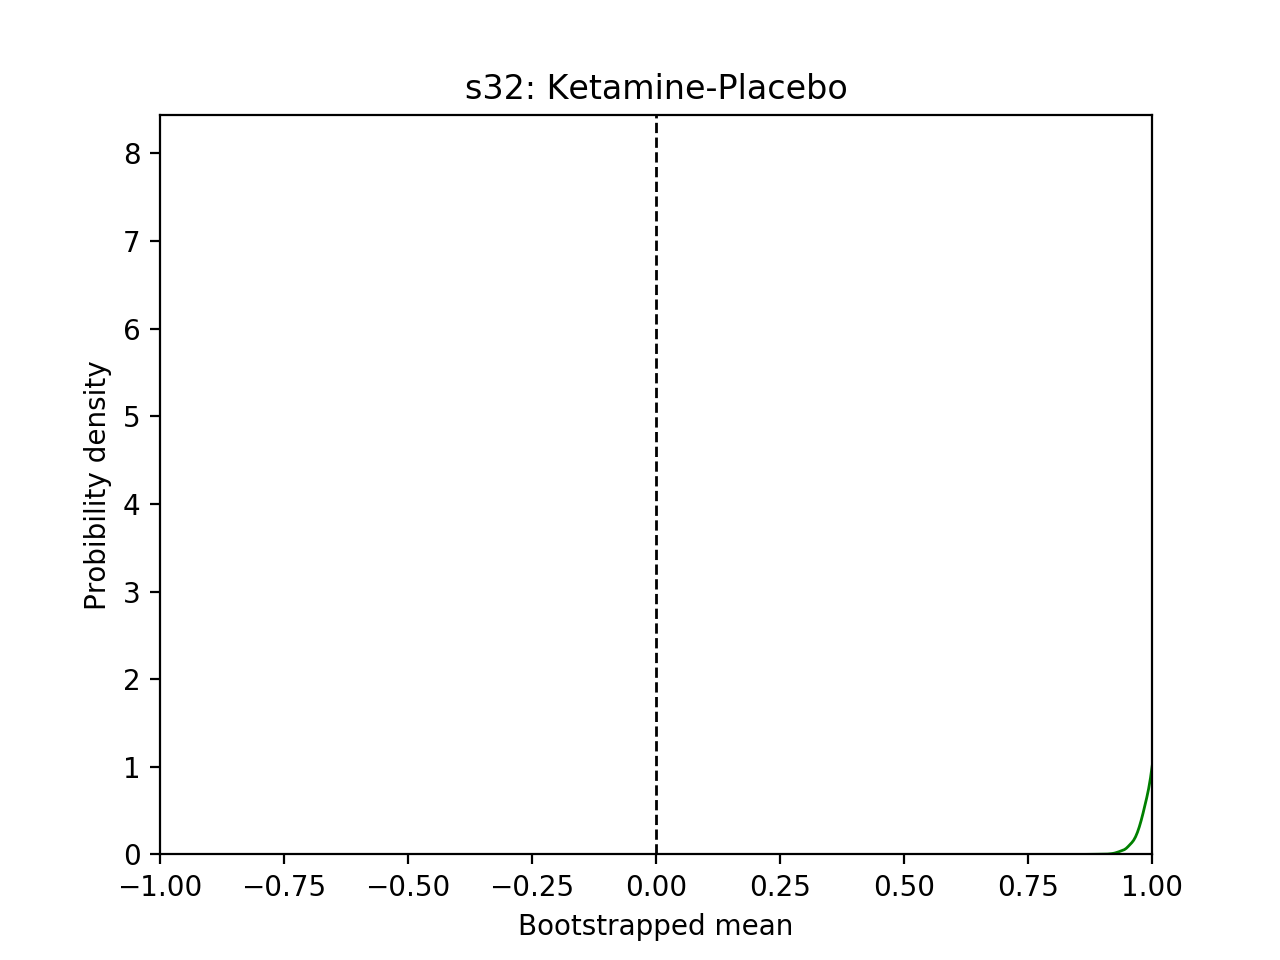

In [144]:
plot_interaction(bsr_com, 's32')

In [146]:
calulcate_p_value_2(bsr)

P value:  0.0


# s24

In [173]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('s24')

<IPython.core.display.Javascript object>


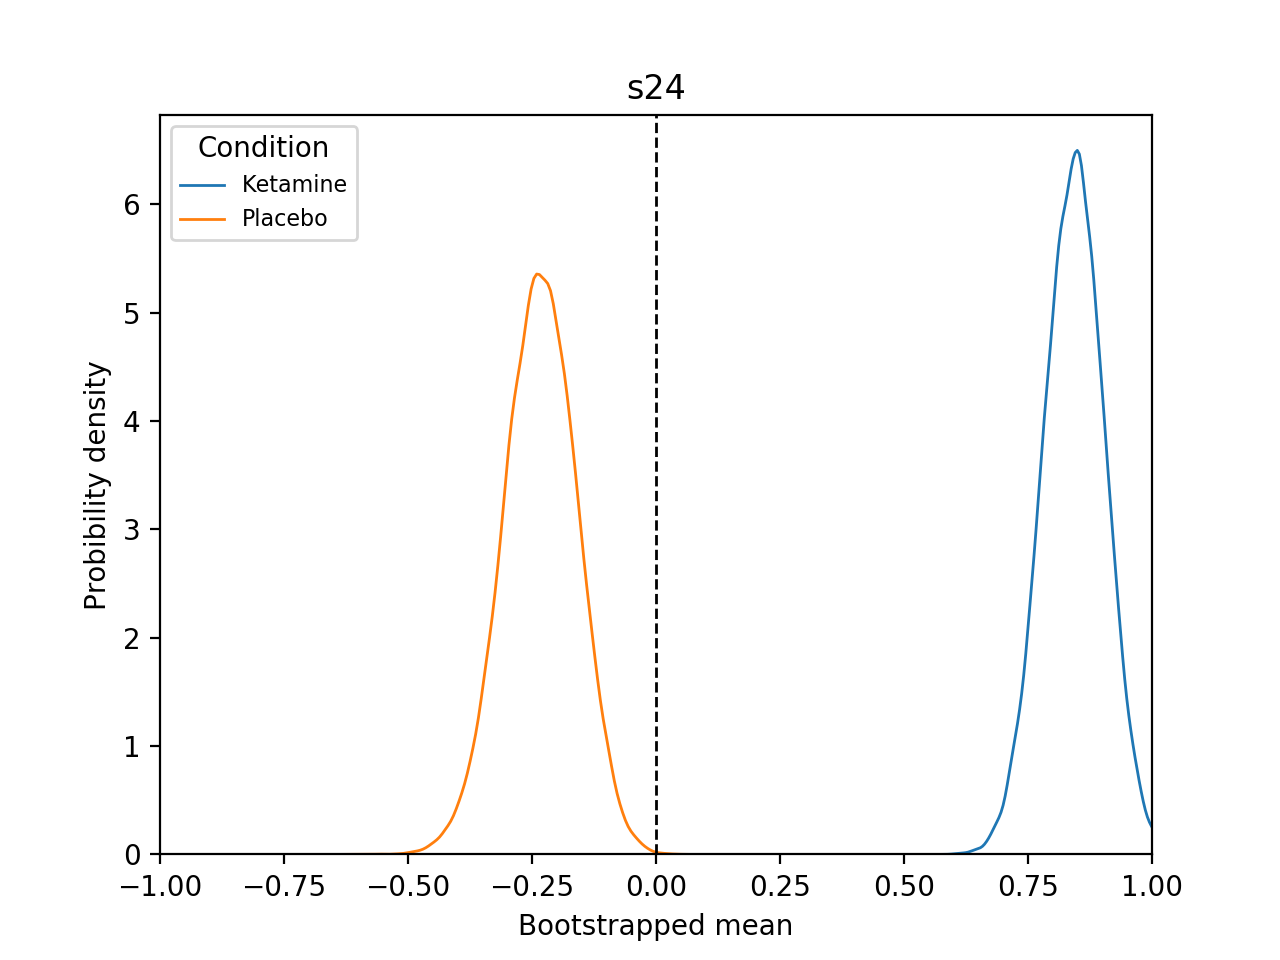

In [174]:
plot_ket_placebo(bsr_com, 's24')

In [175]:
calulcate_p_value_2(bsr_k)

P value:  0.0


In [177]:
calulcate_p_value_1(bsr_p)

P value:  0.00076


<IPython.core.display.Javascript object>


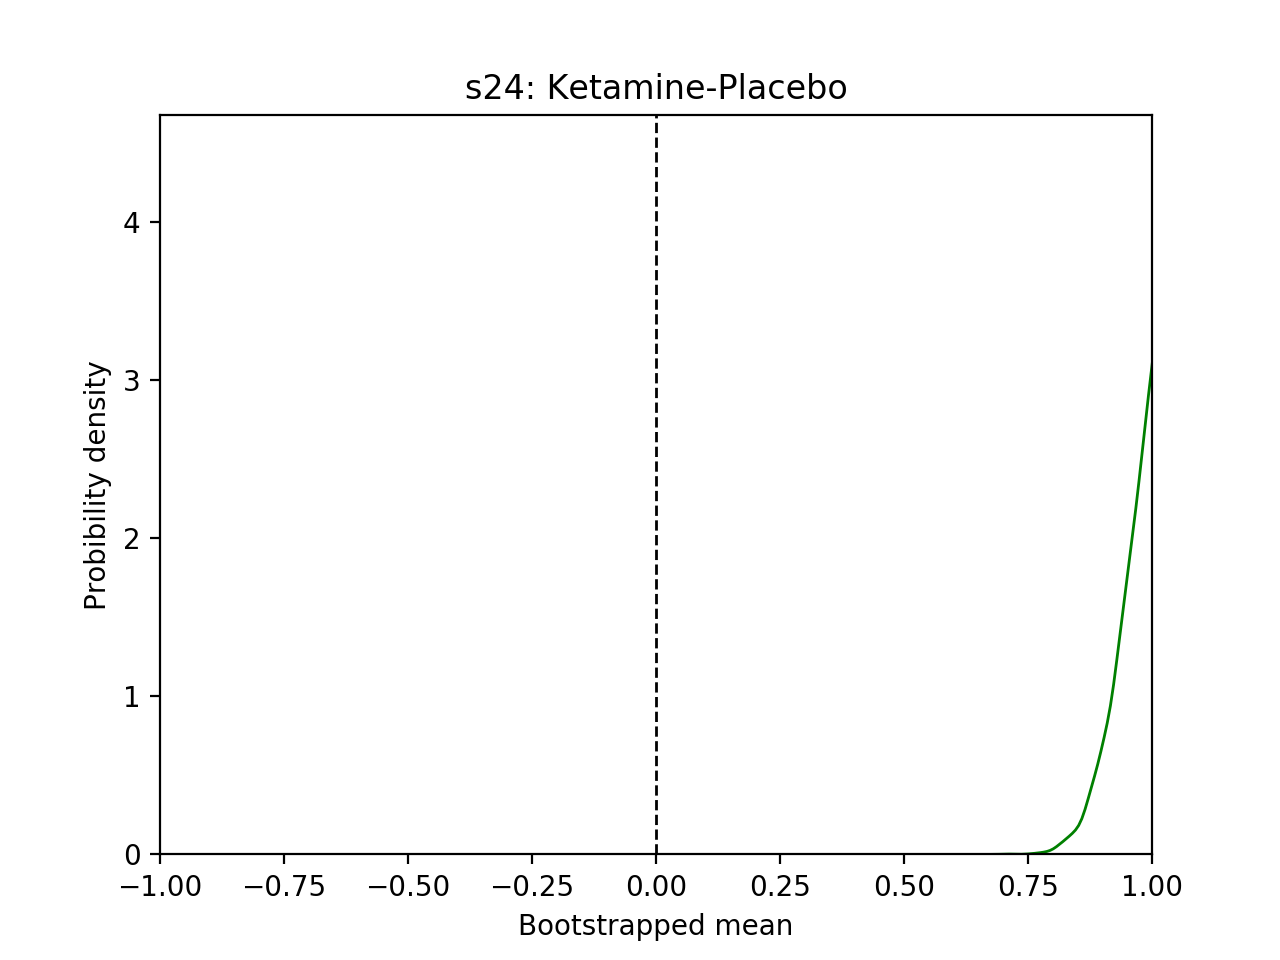

In [178]:
plot_interaction(bsr_com, 's24')

In [179]:
calulcate_p_value_2(bsr)

P value:  0.0


# p32

In [180]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('p32')

<IPython.core.display.Javascript object>


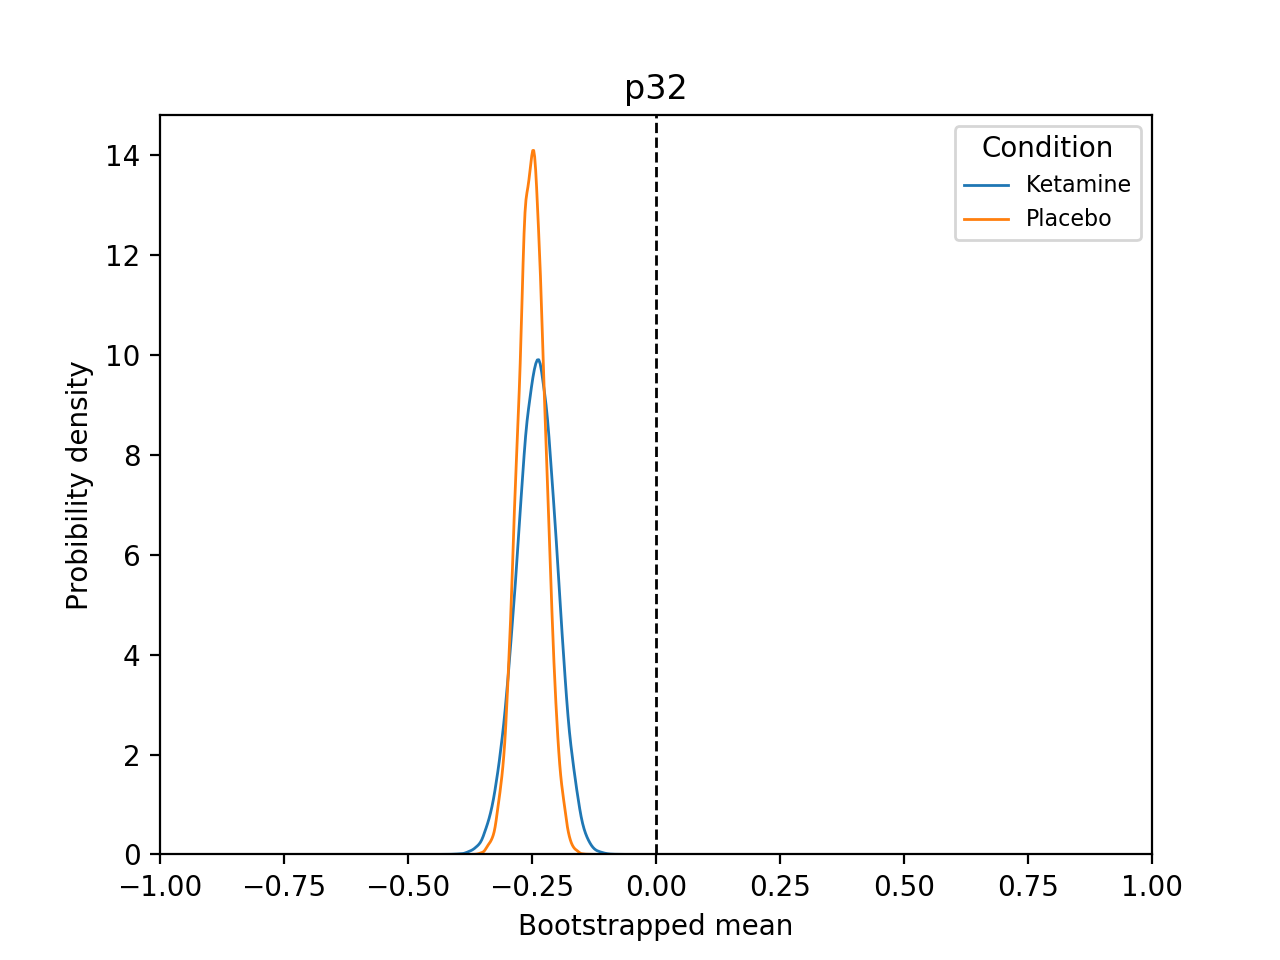

In [181]:
plot_ket_placebo(bsr_com, 'p32')

In [184]:
calulcate_p_value_1(bsr_k)

P value:  0.0


In [185]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


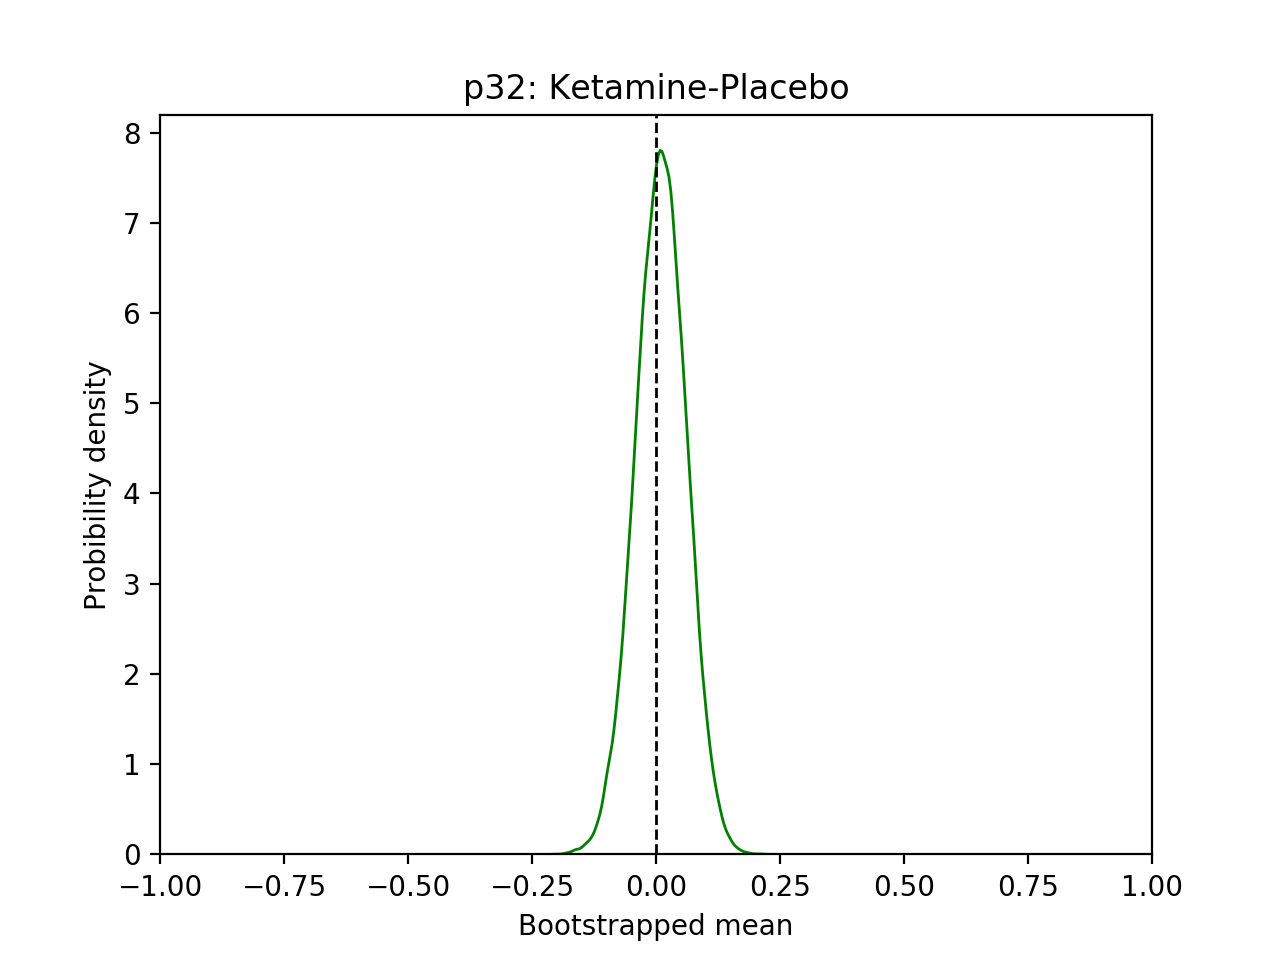

In [186]:
plot_interaction(bsr_com, 'p32')

In [187]:
calulcate_p_value_2(bsr)

P value:  0.8354


# Caudate

In [147]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('Caudate')

<IPython.core.display.Javascript object>


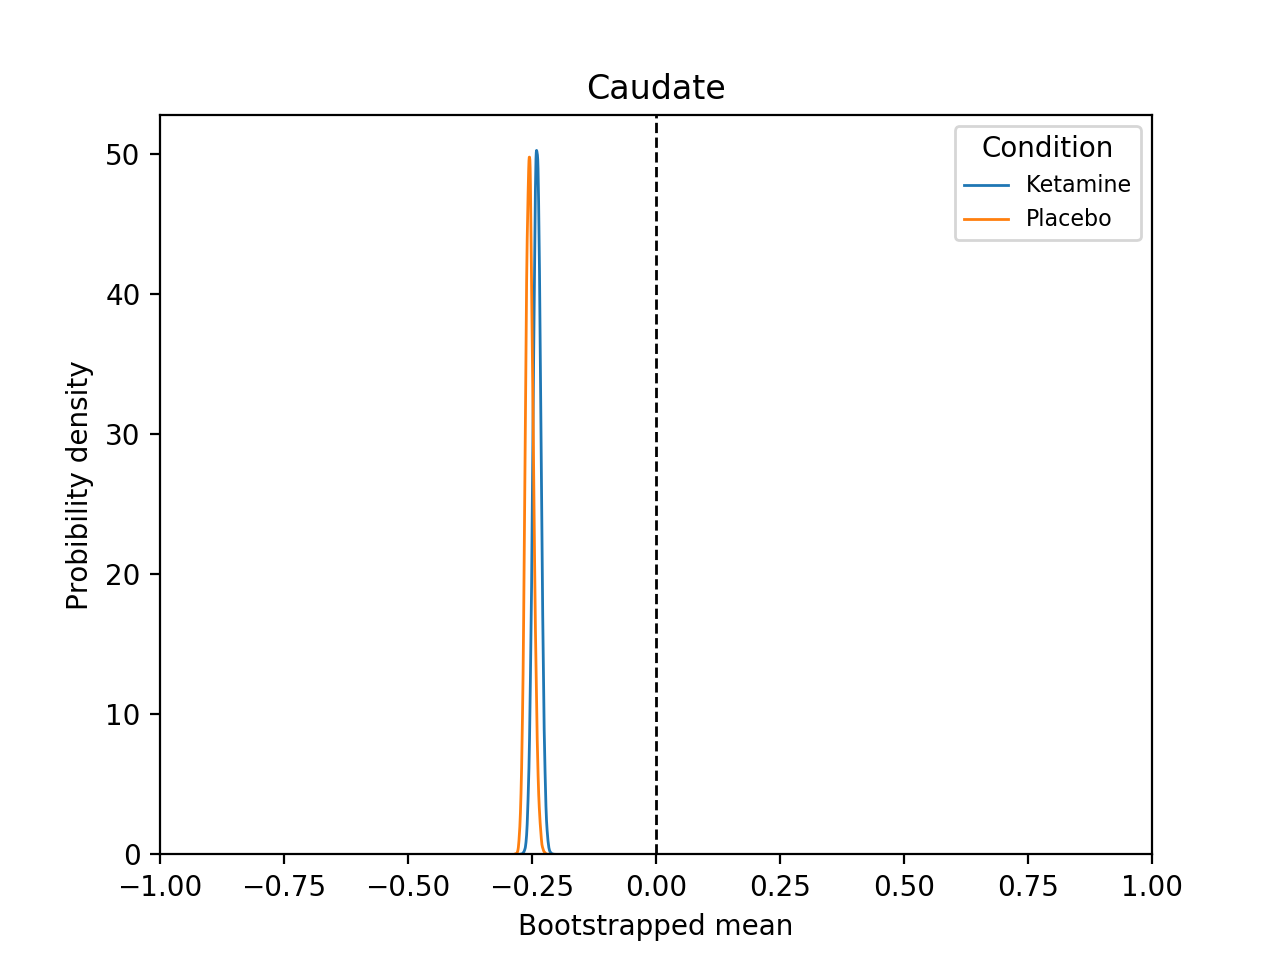

In [150]:
plot_ket_placebo(bsr_com, 'Caudate')

<IPython.core.display.Javascript object>


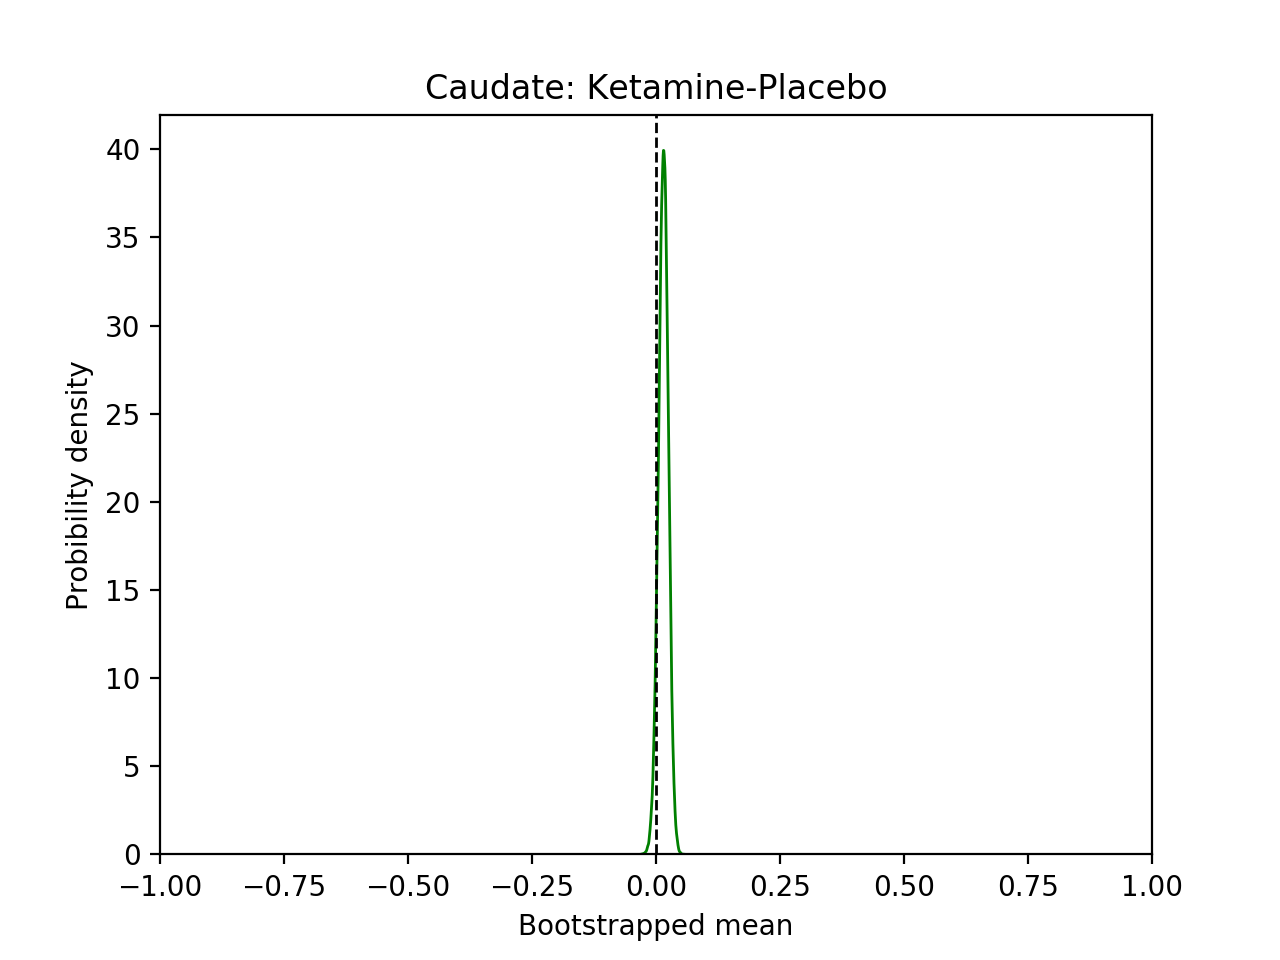

In [149]:
plot_interaction(bsr_com, 'Caudate')

# Putamen

In [151]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('Putamen')

<IPython.core.display.Javascript object>


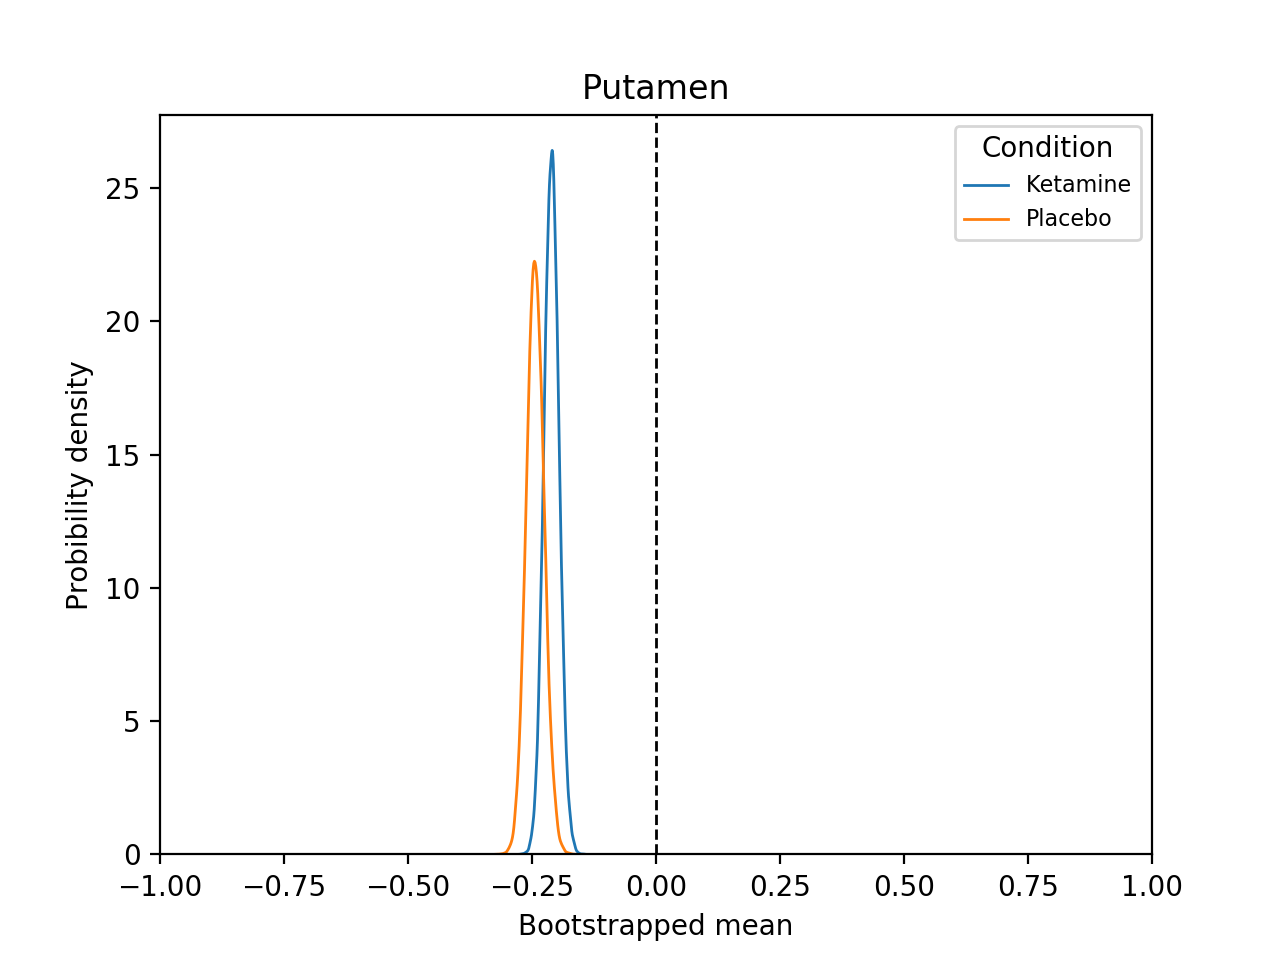

In [152]:
plot_ket_placebo(bsr_com, 'Putamen')

In [153]:
calulcate_p_value_1(bsr_k)

P value:  0.0


In [154]:
calulcate_p_value_1(bsr_p)

P value:  0.0


<IPython.core.display.Javascript object>


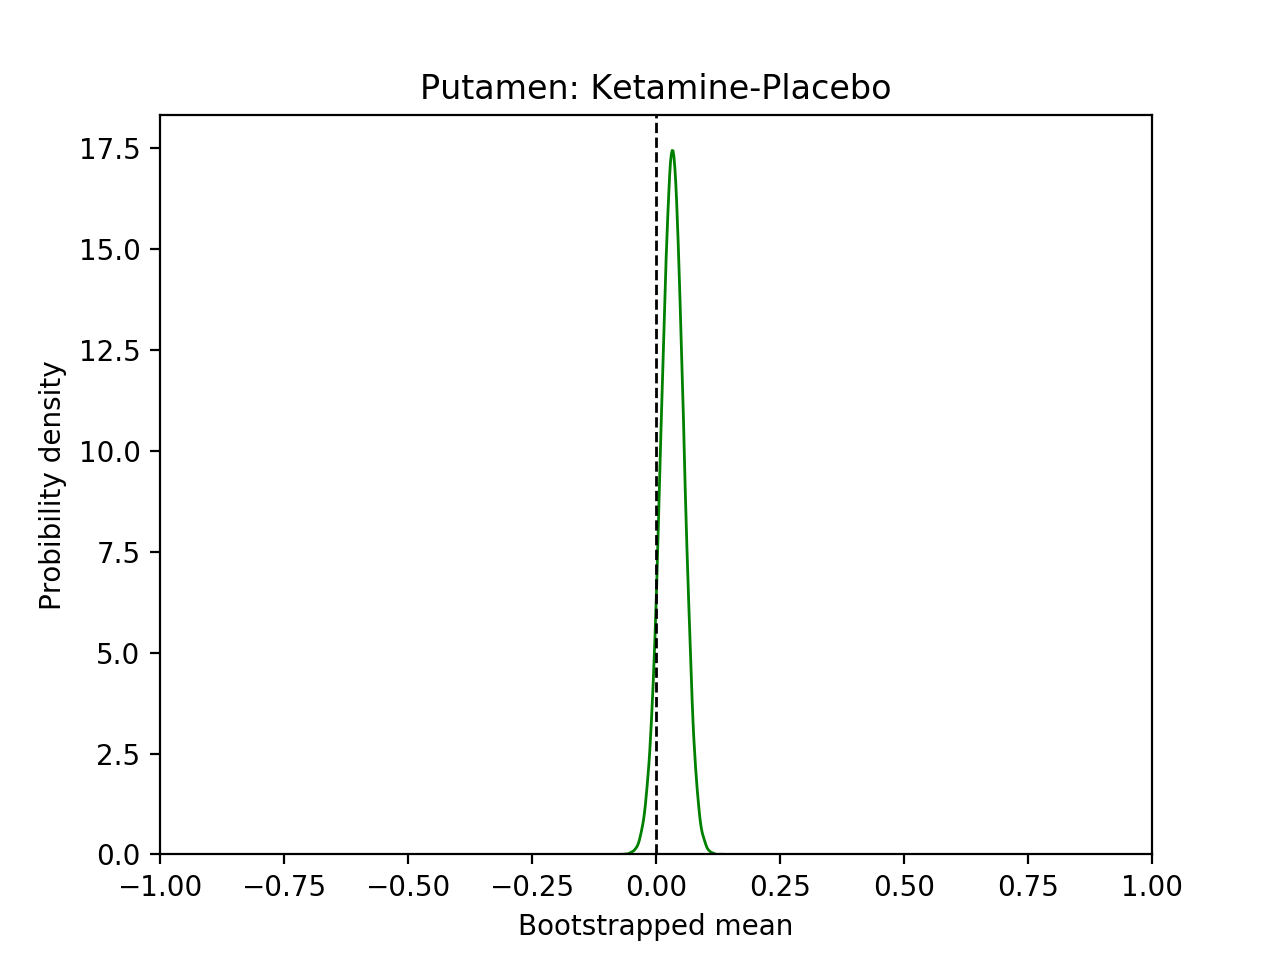

In [155]:
plot_interaction(bsr_com, 'Putamen')

In [157]:
calulcate_p_value_2(bsr)

P value:  0.15704


# NAcc

In [158]:
[bsr_com, bsr_k, bsr_p, bsr] = calculate_bootstrap('NAcc')

<IPython.core.display.Javascript object>


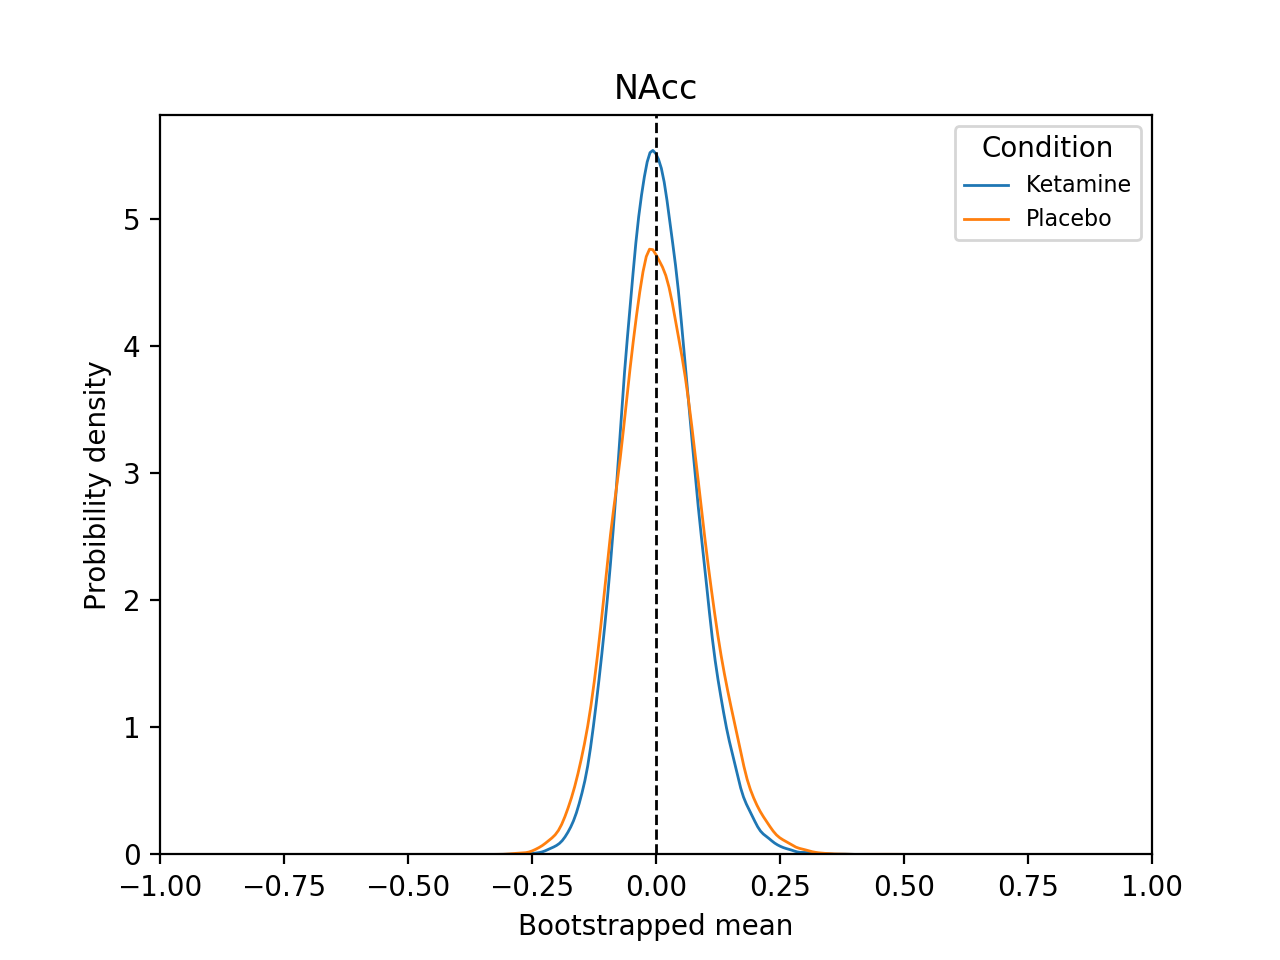

In [159]:
plot_ket_placebo(bsr_com, 'NAcc')

<IPython.core.display.Javascript object>


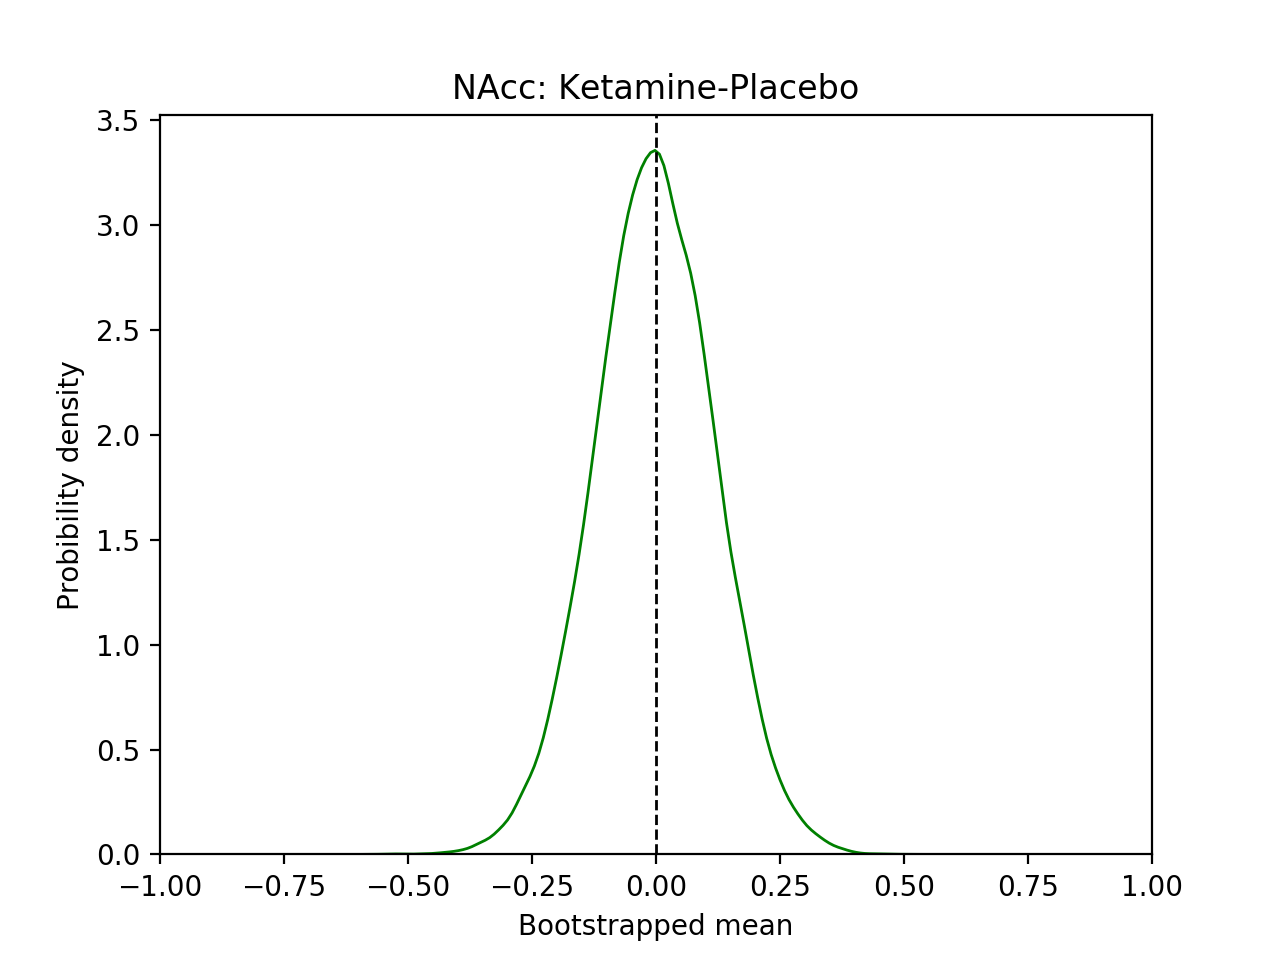

In [160]:
plot_interaction(bsr_com, 'NAcc')